# Ciência e visualização de dados na Saúde

## Determinação de informações relevantes para classificação de fracasso clínico após cateterismo

### Modelagem

#### Danielle Lanzarini Pinto      RA: 116559
#### Jampierre Vieira Rocha       RA: 231372
#### Tito Barbosa Rezende         RA: 025327


In [1]:
import numpy as np
import pandas as pd
import collections
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import VotingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import graphviz
from graphviz import Source
import os
import math
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
%matplotlib inline

#### Auxiliary functions

In [2]:
def boldprint(text):
    print ('\033[1m'+text+'\033[0m')

In [3]:
def print_column_names(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df.iloc[0][:])

In [4]:
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "plot_feature_importances"
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt
    from lightgbm import LGBMClassifier
    
    from xgboost.core     import XGBoostError
    from lightgbm.sklearn import LightGBMError
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
#                 raise AttributeError("{} does not have feature_importances_ attribute".
#                                     format(clf.__class__.__name__))
                print("{} does not have feature_importances_ attribute".format(clf.__class__.__name__))
                return None
                
    except (XGBoostError, LightGBMError, ValueError):
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.barh(feat_imp.index.values, feat_imp.loc[:,'importance'])
    ax.set_xlabel('Feature Importance Score')
    ax.set_xlim(0,1)
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

## Load Dataset

In [5]:
DATASET_PATH= '../dataset/'

In [6]:
merged_df = pd.read_csv(DATASET_PATH + 'V2_train_df.csv', index_col=0, low_memory=False)
test_df = pd.read_csv(DATASET_PATH + 'V2_test_df.csv', index_col=0, low_memory=False)

## Prepare data

In [8]:
merged_df.drop(columns=[col for col in merged_df.columns if ('_Nº. Paciente' in col) or ('_Nº da Intervenção' in col)], inplace=True)
test_df.drop(columns=[col for col in test_df.columns if ('_Nº. Paciente' in col) or ('_Nº da Intervenção' in col)], inplace=True)

## Train Test Split

In [9]:
MINIMUM_SAMPLES = 10

In [15]:
def split_train_valid(df, y_column, strategy, simpleImputer=False):

    if simpleImputer:
        x_df = df.filter(items=[col for col in df.columns if ('evolucao_' not in col)], axis=1)
        #A estratégia de imputação precisa ser melhorada e definida juntamente com o especialista médico.
        imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
        imp = imp.fit(x_df)
        x_df = pd.DataFrame(data= imp.transform(x_df), columns=x_df.columns, index= x_df.index)
    else:
        x_df = df.filter(items=[col for col in df.columns if ('evolucao_' not in col)], axis=1)
    
    y_df = df.filter(items=[y_column], axis=1)
    
    X, X_valid, y, y_valid = train_test_split(x_df, y_df, test_size=0.2, random_state=42)

    min_n_samples = np.min(y.iloc[:,0].value_counts())
    if (min_n_samples < MINIMUM_SAMPLES):
        raise Exception('Bellow MINIMUM_SAMPLES ', y_column)
        
    if strategy == 'ADASYN':
        ovrsmp = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
        X_res, y_res = ovrsmp.fit_resample(X, y)
    elif strategy == 'RandomOverSampler':
        ovrsmp = RandomOverSampler(random_state=42)
        X_res, y_res = ovrsmp.fit_resample(X, y)
    elif strategy == 'SMOTE':
        ovrsmp = SMOTE(random_state=42, k_neighbors=5)
        X_res, y_res = ovrsmp.fit_resample(X, y)
    elif strategy == 'RandomUnderSampler':
        smp = RandomUnderSampler(random_state=42)
        X_res, y_res = smp.fit_resample(X,y)
    elif strategy == 'imbalanced':
        X_res = X
        y_res = y
    else:
        raise Exception('strategy %s not suported' % strategy)

    return {'X':X_res, 'X_valid': X_valid, 'y': y_res, 'y_valid': y_valid}

In [19]:
dataset = {}
for table in ["imputed", "not_imputed"]:
    boldprint(table)
    strategies = ['imbalanced','RandomOverSampler','RandomUnderSampler','ADASYN','SMOTE']
    dataset[table] = {}
    for strategy in strategies:
        boldprint(strategy)
        y_columns = [col for col in merged_df.columns if ('evolucao_' in col)]
        dataset[table][strategy] = {}
        for col in y_columns:
            try:
                impute = True if table == "imputed" else False
                dataset[table][strategy][col] = split_train_valid(merged_df, col, strategy, impute)
                print(col)
                print('training')
                print(dataset[table][strategy][col]['y'].iloc[:,0].value_counts())
                print('validation')
                print(dataset[table][strategy][col]['y_valid'].iloc[:,0].value_counts())

                if (dataset[table][strategy][col]['y'].iloc[:,0].value_counts().shape != (2,) or dataset[table][strategy][col]['y_valid'].iloc[:,0].value_counts().shape != (2,)):
                    print('Removing label ', col)
                    del dataset[table][strategy][col]
                    continue

                if (dataset[table][strategy][col]['y'].iloc[:,0].value_counts()[1] <= MINIMUM_SAMPLES or dataset[table][strategy][col]['y_valid'].iloc[:,0].value_counts()[1] <= MINIMUM_SAMPLES):
                    print('Removing label ', col)
                    del dataset[table][strategy][col]
                    continue
            except Exception as error:
                print('Skiping col ', col, error)
            print()

imputed
imbalanced
evolucao_Problema Clínico
training
0    5938
1     240
Name: evolucao_Problema Clínico, dtype: int64
validation
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64

evolucao_Infarto após Intervenção
training
0    6064
1     114
Name: evolucao_Infarto após Intervenção, dtype: int64
validation
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64

evolucao_Óbito Hospitalar
training
0    6096
1      82
Name: evolucao_Óbito Hospitalar, dtype: int64
validation
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64

evolucao_Complicação Vascular
training
0    6152
1      26
Name: evolucao_Complicação Vascular, dtype: int64
validation
0    1540
1       5
Name: evolucao_Complicação Vascular, dtype: int64
Removing label  evolucao_Complicação Vascular
Skiping col  evolucao_I.R.A ('Bellow MINIMUM_SAMPLES ', 'evolucao_I.R.A')

Skiping col  evolucao_I.R.A Dialítica ('Bellow MINIMUM_SAMPLES ', 'evolucao_I.R.A Dialítica')

Skiping col  e

evolucao_Infarto após Intervenção
training
1    6064
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
validation
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64

evolucao_Óbito Hospitalar
training
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
validation
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64

evolucao_Complicação Vascular
training
1    6152
0    6152
Name: evolucao_Complicação Vascular, dtype: int64
validation
0    1540
1       5
Name: evolucao_Complicação Vascular, dtype: int64
Removing label  evolucao_Complicação Vascular
Skiping col  evolucao_I.R.A ('Bellow MINIMUM_SAMPLES ', 'evolucao_I.R.A')

Skiping col  evolucao_I.R.A Dialítica ('Bellow MINIMUM_SAMPLES ', 'evolucao_I.R.A Dialítica')

Skiping col  evolucao_A.V.C Hemorrágico ('Bellow MINIMUM_SAMPLES ', 'evolucao_A.V.C Hemorrágico')

Skiping col  evolucao_A.V.C Isquêmico ('Bellow MINIMUM_SAMPLES ', 'evolucao_A.V.C Isquêmico')

evolucao_Combinado

In [20]:
def calculate_tpr(model, X, y):
    if model == None:
        return
    
    tpr = 0
    predictions = model.predict(X)
    cm = metrics.confusion_matrix(y.values, predictions)
    if (cm.shape == (2,2)):
            tn, fp, fn, tp = cm.ravel()
            #true positive rate
            tpr = tp/(tp+fn)
    return tpr              
            
def predict(model, X, y, plot_importances=False):
    if model == None:
        return
    
    tpr = 0
    print('Value counts')
    print(y.value_counts())
    print('Score: ', model.score(X, y))
    predictions = model.predict(X)
    cm = metrics.confusion_matrix(y.values, predictions)
    if (cm.shape == (2,2)):
        tn, fp, fn, tp = cm.ravel()
        print('tn:', tn,'fp:', fp,'fn:', fn,'tp:', tp)
        print(metrics.classification_report(y.values, predictions))
        #true positive rate
        if (tp+fn) > 0:
            tpr = tp/(tp+fn)
            print('True positive rate: ', tpr)
        if plot_importances: # and (tpr > 0.3):
            plot_feature_importances(model, X, y, top_n=10, print_table=False, title= y.name)
    else:
        print()
        print('Predictions could not be calculated')
        print()

In [108]:
RETRAIN=False
def fit_model(X, y, classifier="DecisionTree", params_grid={}):
    scoring = ['f1'] # ['balanced_accuracy', 'average_precision','f1']

    print('Fitting ', y.name, ' using ', classifier)
    if (y.value_counts().shape == (2,)):

        if classifier == "DecisionTree":
            model = tree.DecisionTreeClassifier()
        elif classifier == "XGBoost":
            model = XGBClassifier(random_state=42)
        elif classifier == "RandomForestClassifier":
            model = RandomForestClassifier(random_state=42)
        elif classifier == "logistic":
            model = LogisticRegression(random_state=42)
        elif classifier == "svm":
            model = SVC(random_state=42)
        
        
        search = GridSearchCV(model, param_grid=params_grid, cv=5, verbose=0,scoring=scoring, refit="f1", n_jobs=6, return_train_score=True)
        search.fit(X,y)
        print('Best estimator', search.best_estimator_)
        return search.best_estimator_
    else:
        print('skipping model fit due to insufficient positive samples')
    
    return None

def train_models(dataset, params_grid={}):
    print("Training started...")
    classifiers = ["XGBoost", "DecisionTree", "RandomForestClassifier", "logistic", "svm"]
    
    dataset_models = {}
    for name in dataset.keys():
        print("dataset name ", name)
        dataset_models[name] = {}
        for strategy in dataset[name].keys():
            print("dataset strategy", strategy)
            df = dataset[name][strategy]
            labels = []
            models = {}
            for idx, label in enumerate(df.keys()):
                models_per_classifier ={}
                for classifier in classifiers:
                    try:
                        modelname = f'{name}_{strategy}_{label}_{classifier}'
                        
                        if (~RETRAIN and os.path.isfile(modelname + ".model")):
                            print ("file already exists ", modelname)
                        else:
                            print ("training", modelname)
                            bestmodel = fit_model(df[label]['X'], df[label]['y'].iloc[:,0], classifier, params_grid)
                            pickle.dump(bestmodel, open(modelname + ".model", "wb"))
                            
                        models_per_classifier[classifier] = modelname
                    except Exception as error:
                        #Alguns modelos não conseguem lidar com dado faltante e serão ignorados quando houver erro
                        print('Training error', name, strategy, label, classifier, error)
                models[label] = models_per_classifier   
            dataset_models[name][strategy] = models    

    print("Evaluations started...")
    for name in dataset.keys():
        boldprint("Dataset: " + name)
        for strategy in dataset[name].keys():
            print("strategy", strategy)
            df = dataset[name][strategy]
            for label in df.keys():
                print("dataset label", label)
                for classifier in classifiers:
                    try:
                        modelname = dataset_models[name][strategy][label][classifier]
                        if os.path.isfile(modelname + ".model"):
                            file = open(modelname+'.model', 'rb')
                            bestmodel = pickle.load(file)
                            print('Predictions for ', modelname)
                            print('Predicting on traning...' + modelname)
                            predict(bestmodel, df[label]['X'], df[label]['y'].iloc[:,0])
                            print('Predicting on validation...' + modelname)
                            predict(bestmodel, df[label]['X_valid'], df[label]['y_valid'].iloc[:,0], True)
                            print()
                        else:
                            print('Model not found', modelname)
                    except:
                        print('skipping', name, strategy, label, classifier)
    return dataset_models

### Results

Training started...
dataset name  imputed
dataset strategy imbalanced
file already exists  imputed_imbalanced_evolucao_Problema Clínico_XGBoost
file already exists  imputed_imbalanced_evolucao_Problema Clínico_DecisionTree
file already exists  imputed_imbalanced_evolucao_Problema Clínico_RandomForestClassifier
file already exists  imputed_imbalanced_evolucao_Problema Clínico_logistic
file already exists  imputed_imbalanced_evolucao_Problema Clínico_svm
file already exists  imputed_imbalanced_evolucao_Infarto após Intervenção_XGBoost
file already exists  imputed_imbalanced_evolucao_Infarto após Intervenção_DecisionTree
file already exists  imputed_imbalanced_evolucao_Infarto após Intervenção_RandomForestClassifier
file already exists  imputed_imbalanced_evolucao_Infarto após Intervenção_logistic
file already exists  imputed_imbalanced_evolucao_Infarto após Intervenção_svm
file already exists  imputed_imbalanced_evolucao_Óbito Hospitalar_XGBoost
file already exists  imputed_imbalanced_ev

Training error not_imputed imbalanced evolucao_Problema Clínico DecisionTree Input contains NaN, infinity or a value too large for dtype('float32').
training not_imputed_imbalanced_evolucao_Problema Clínico_RandomForestClassifier
Fitting  evolucao_Problema Clínico  using  RandomForestClassifier
Training error not_imputed imbalanced evolucao_Problema Clínico RandomForestClassifier Input contains NaN, infinity or a value too large for dtype('float32').
training not_imputed_imbalanced_evolucao_Problema Clínico_logistic
Fitting  evolucao_Problema Clínico  using  logistic
Training error not_imputed imbalanced evolucao_Problema Clínico logistic Input contains NaN, infinity or a value too large for dtype('float64').
training not_imputed_imbalanced_evolucao_Problema Clínico_svm
Fitting  evolucao_Problema Clínico  using  svm
Training error not_imputed imbalanced evolucao_Problema Clínico svm Input contains NaN, infinity or a value too large for dtype('float64').
file already exists  not_imputed

Training error not_imputed RandomOverSampler evolucao_Óbito Hospitalar svm Input contains NaN, infinity or a value too large for dtype('float64').
file already exists  not_imputed_RandomOverSampler_evolucao_Combinado_XGBoost
training not_imputed_RandomOverSampler_evolucao_Combinado_DecisionTree
Fitting  evolucao_Combinado  using  DecisionTree
Training error not_imputed RandomOverSampler evolucao_Combinado DecisionTree Input contains NaN, infinity or a value too large for dtype('float32').
training not_imputed_RandomOverSampler_evolucao_Combinado_RandomForestClassifier
Fitting  evolucao_Combinado  using  RandomForestClassifier
Training error not_imputed RandomOverSampler evolucao_Combinado RandomForestClassifier Input contains NaN, infinity or a value too large for dtype('float32').
training not_imputed_RandomOverSampler_evolucao_Combinado_logistic
Fitting  evolucao_Combinado  using  logistic
Training error not_imputed RandomOverSampler evolucao_Combinado logistic Input contains NaN, in

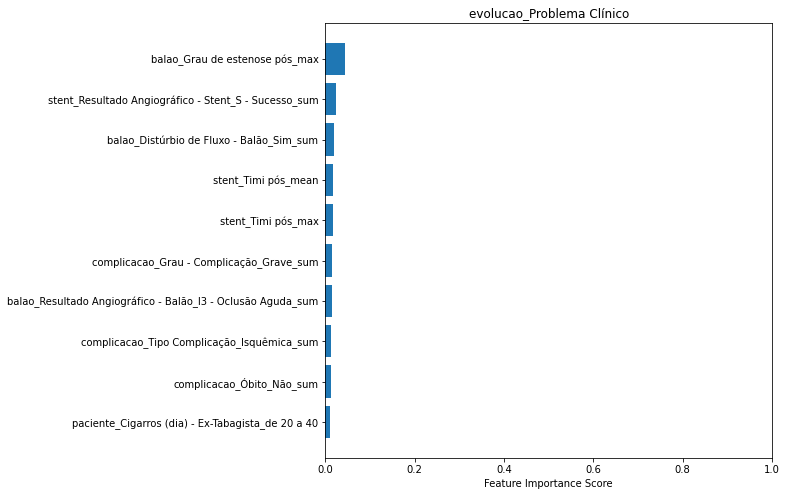


Predictions for  imputed_imbalanced_evolucao_Problema Clínico_DecisionTree
Predicting on traning...imputed_imbalanced_evolucao_Problema Clínico_DecisionTree
Value counts
0    5938
1     240
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 5938 fp: 0 fn: 0 tp: 240
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5938
           1       1.00      1.00      1.00       240

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...imputed_imbalanced_evolucao_Problema Clínico_DecisionTree
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9359223300970874
tn: 1428 fp: 53 fn: 46 tp: 18
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1481
           1       0.25      0.28      0

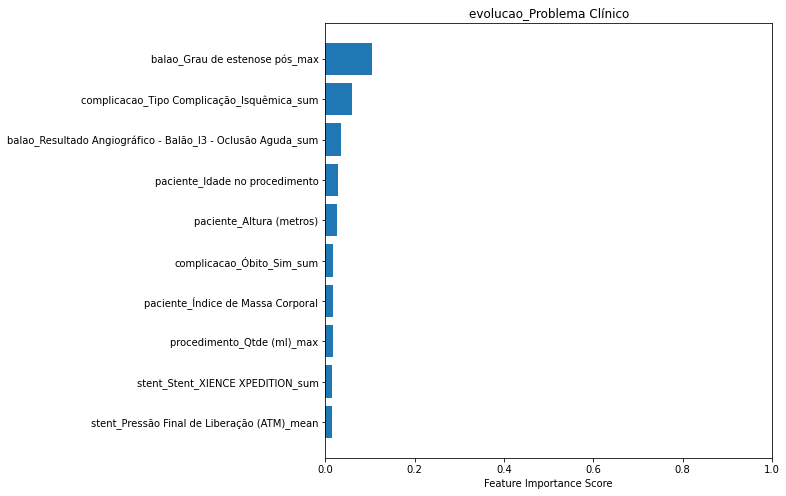


Predictions for  imputed_imbalanced_evolucao_Problema Clínico_RandomForestClassifier
Predicting on traning...imputed_imbalanced_evolucao_Problema Clínico_RandomForestClassifier
Value counts
0    5938
1     240
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 5938 fp: 0 fn: 0 tp: 240
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5938
           1       1.00      1.00      1.00       240

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...imputed_imbalanced_evolucao_Problema Clínico_RandomForestClassifier
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9618122977346278
tn: 1479 fp: 2 fn: 57 tp: 7
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1481
           1

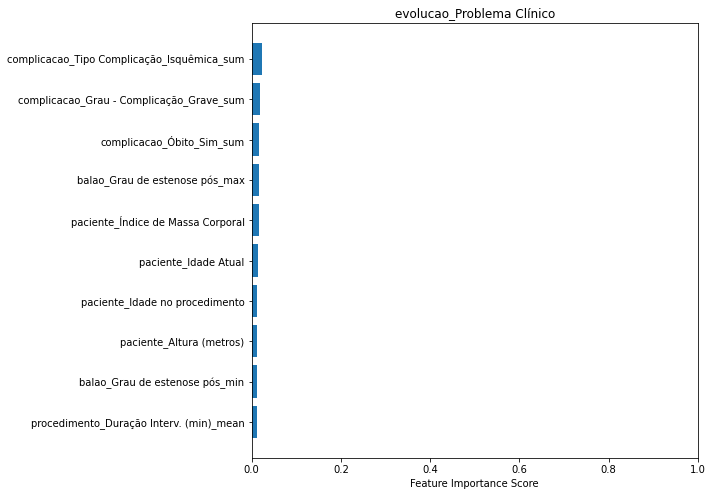


Predictions for  imputed_imbalanced_evolucao_Problema Clínico_logistic
Predicting on traning...imputed_imbalanced_evolucao_Problema Clínico_logistic
Value counts
0    5938
1     240
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9622855292975073
tn: 5913 fp: 25 fn: 208 tp: 32
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5938
           1       0.56      0.13      0.22       240

    accuracy                           0.96      6178
   macro avg       0.76      0.56      0.60      6178
weighted avg       0.95      0.96      0.95      6178

True positive rate:  0.13333333333333333
Predicting on validation...imputed_imbalanced_evolucao_Problema Clínico_logistic
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9598705501618123
tn: 1472 fp: 9 fn: 53 tp: 11
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1481
           1       0

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_imbalanced_evolucao_Problema Clínico_svm
Predicting on traning...imputed_imbalanced_evolucao_Problema Clínico_svm
Value counts
0    5938
1     240
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9614762058918744
tn: 5938 fp: 0 fn: 238 tp: 2
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5938
           1       1.00      0.01      0.02       240

    accuracy                           0.96      6178
   macro avg       0.98      0.50      0.50      6178
weighted avg       0.96      0.96      0.94      6178

True positive rate:  0.008333333333333333
Predicting on validation...imputed_imbalanced_evolucao_Problema Clínico_svm
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9585760517799353
tn: 1481 fp: 0 fn: 64 tp: 0
              precision    recall  f1-score   support

           0       0.96    

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC does not have feature_importances_ attribute

dataset label evolucao_Infarto após Intervenção
Predictions for  imputed_imbalanced_evolucao_Infarto após Intervenção_XGBoost
Predicting on traning...imputed_imbalanced_evolucao_Infarto após Intervenção_XGBoost
Value counts
0    6064
1     114
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 114
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00       114

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...imputed_imbalanced_evolucao_Infarto após Intervenção_XGBoost
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.973462783171521
tn: 1504 fp: 1 fn: 40 tp: 0
              precision    rec

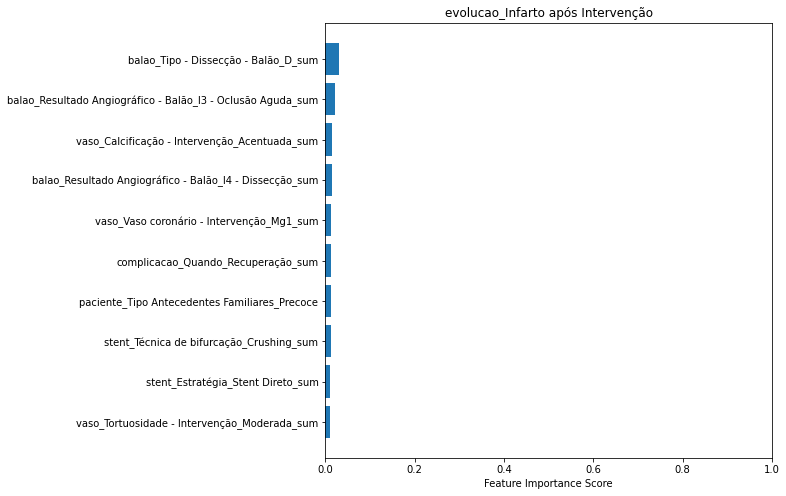


Predictions for  imputed_imbalanced_evolucao_Infarto após Intervenção_DecisionTree
Predicting on traning...imputed_imbalanced_evolucao_Infarto após Intervenção_DecisionTree
Value counts
0    6064
1     114
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 114
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00       114

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...imputed_imbalanced_evolucao_Infarto após Intervenção_DecisionTree
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9598705501618123
tn: 1481 fp: 24 fn: 38 tp: 2
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1505
 

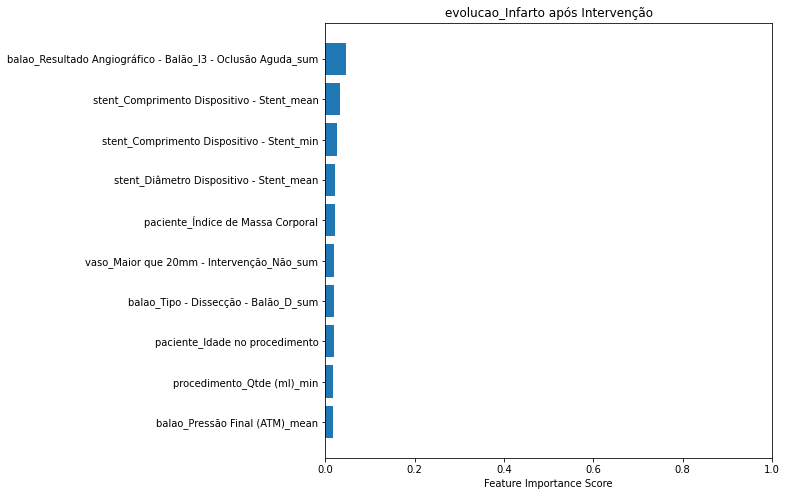


Predictions for  imputed_imbalanced_evolucao_Infarto após Intervenção_RandomForestClassifier
Predicting on traning...imputed_imbalanced_evolucao_Infarto após Intervenção_RandomForestClassifier
Value counts
0    6064
1     114
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 114
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00       114

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...imputed_imbalanced_evolucao_Infarto após Intervenção_RandomForestClassifier
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9741100323624595
tn: 1505 fp: 0 fn: 40 tp: 0
              precision    recall  f1-score   support

           0       0.97   

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


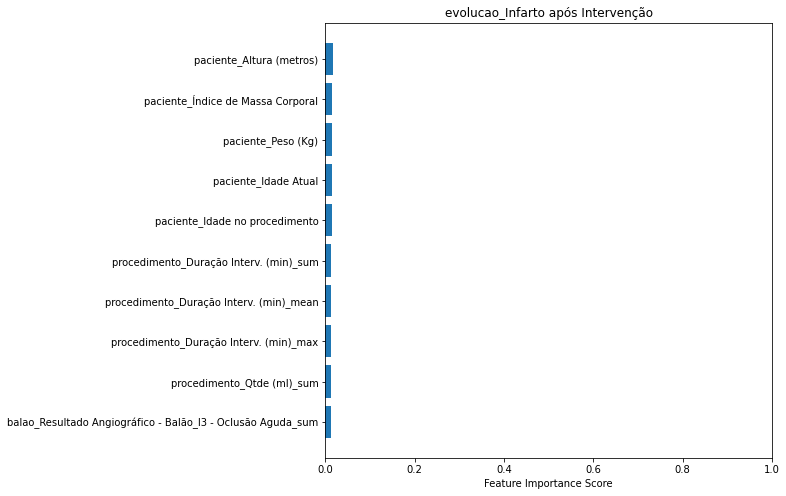


Predictions for  imputed_imbalanced_evolucao_Infarto após Intervenção_logistic
Predicting on traning...imputed_imbalanced_evolucao_Infarto após Intervenção_logistic
Value counts
0    6064
1     114
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9813855616704436
tn: 6061 fp: 3 fn: 112 tp: 2
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6064
           1       0.40      0.02      0.03       114

    accuracy                           0.98      6178
   macro avg       0.69      0.51      0.51      6178
weighted avg       0.97      0.98      0.97      6178

True positive rate:  0.017543859649122806
Predicting on validation...imputed_imbalanced_evolucao_Infarto após Intervenção_logistic
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9741100323624595
tn: 1505 fp: 0 fn: 40 tp: 0
              precision    recall  f1-score   support

           0       0.97      1.00   

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_imbalanced_evolucao_Infarto após Intervenção_svm
Predicting on traning...imputed_imbalanced_evolucao_Infarto após Intervenção_svm
Value counts
0    6064
1     114
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9817092910326967
tn: 6064 fp: 0 fn: 113 tp: 1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6064
           1       1.00      0.01      0.02       114

    accuracy                           0.98      6178
   macro avg       0.99      0.50      0.50      6178
weighted avg       0.98      0.98      0.97      6178

True positive rate:  0.008771929824561403
Predicting on validation...imputed_imbalanced_evolucao_Infarto após Intervenção_svm
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9741100323624595
tn: 1505 fp: 0 fn: 40 tp: 0
              precision    recall  f1-scor

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC does not have feature_importances_ attribute

dataset label evolucao_Óbito Hospitalar
Predictions for  imputed_imbalanced_evolucao_Óbito Hospitalar_XGBoost
Predicting on traning...imputed_imbalanced_evolucao_Óbito Hospitalar_XGBoost
Value counts
0    6096
1      82
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 82
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00        82

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...imputed_imbalanced_evolucao_Óbito Hospitalar_XGBoost
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9896440129449838
tn: 1527 fp: 7 fn: 9 tp: 2
              precision    recall  f1-score   support

           0       0.99 

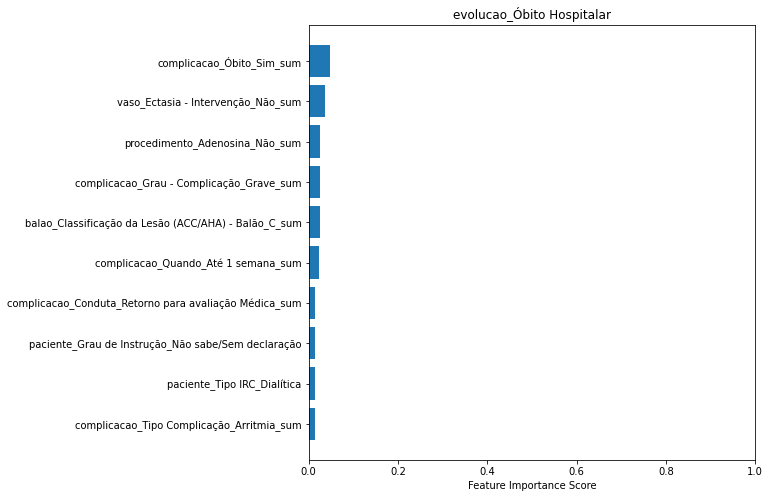


Predictions for  imputed_imbalanced_evolucao_Óbito Hospitalar_DecisionTree
Predicting on traning...imputed_imbalanced_evolucao_Óbito Hospitalar_DecisionTree
Value counts
0    6096
1      82
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 82
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00        82

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...imputed_imbalanced_evolucao_Óbito Hospitalar_DecisionTree
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9844660194174757
tn: 1519 fp: 15 fn: 9 tp: 2
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1534
           1       0.12      0.18      0.14

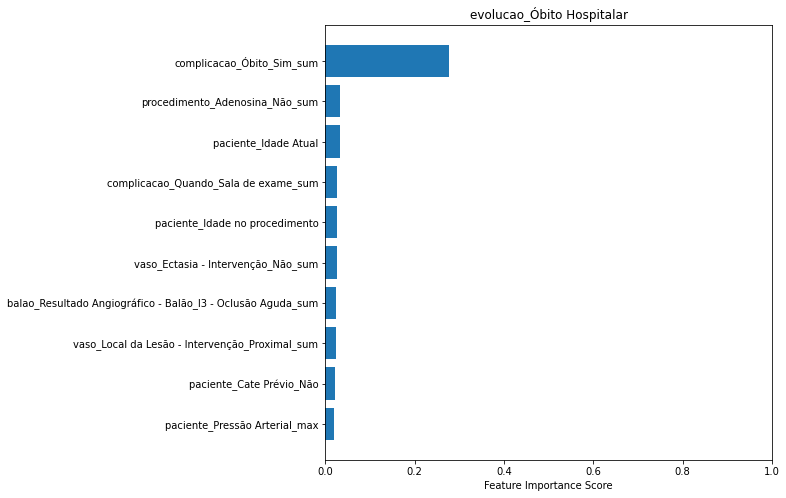


Predictions for  imputed_imbalanced_evolucao_Óbito Hospitalar_RandomForestClassifier
Predicting on traning...imputed_imbalanced_evolucao_Óbito Hospitalar_RandomForestClassifier
Value counts
0    6096
1      82
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 82
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00        82

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...imputed_imbalanced_evolucao_Óbito Hospitalar_RandomForestClassifier
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9928802588996763
tn: 1534 fp: 0 fn: 11 tp: 0
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1534
           1 

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


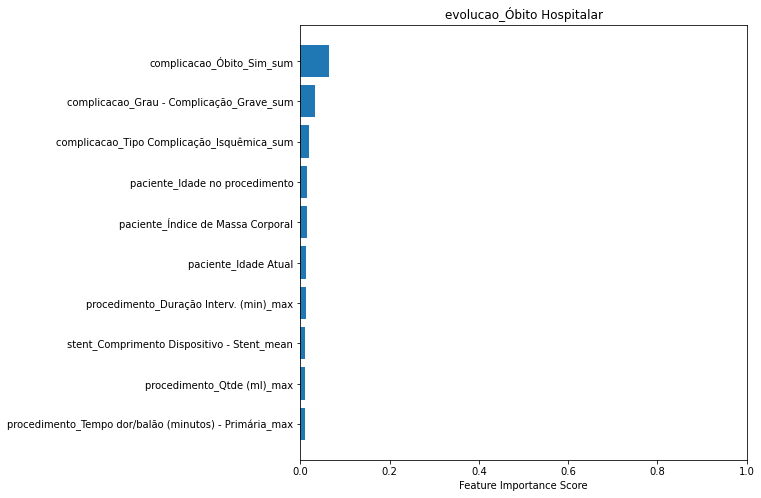


Predictions for  imputed_imbalanced_evolucao_Óbito Hospitalar_logistic
Predicting on traning...imputed_imbalanced_evolucao_Óbito Hospitalar_logistic
Value counts
0    6096
1      82
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.986565231466494
tn: 6091 fp: 5 fn: 78 tp: 4
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6096
           1       0.44      0.05      0.09        82

    accuracy                           0.99      6178
   macro avg       0.72      0.52      0.54      6178
weighted avg       0.98      0.99      0.98      6178

True positive rate:  0.04878048780487805
Predicting on validation...imputed_imbalanced_evolucao_Óbito Hospitalar_logistic
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9928802588996763
tn: 1534 fp: 0 fn: 11 tp: 0
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1534
           1       0.00  

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_imbalanced_evolucao_Óbito Hospitalar_svm
Predicting on traning...imputed_imbalanced_evolucao_Óbito Hospitalar_svm
Value counts
0    6096
1      82
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9867270961476206
tn: 6096 fp: 0 fn: 82 tp: 0
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6096
           1       0.00      0.00      0.00        82

    accuracy                           0.99      6178
   macro avg       0.49      0.50      0.50      6178
weighted avg       0.97      0.99      0.98      6178

True positive rate:  0.0
Predicting on validation...imputed_imbalanced_evolucao_Óbito Hospitalar_svm
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Score:  0.9928802588996763
tn: 1534 fp: 0 fn: 11 tp: 0
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1534
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1545
   macro avg       0.50      0.50      0.50      1545
weighted avg       0.99      0.99      0.99      1545

True positive rate:  0.0
SVC does not have feature_importances_ attribute

dataset label evolucao_Combinado
Predictions for  imputed_imbalanced_evolucao_Combinado_XGBoost
Predicting on traning...imputed_imbalanced_evolucao_Combinado_XGBoost
Value counts
0    5910
1     268
Name: evolucao_Combinado, dtype: int64
Score:  0.9998381353188734


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


tn: 5910 fp: 0 fn: 1 tp: 267
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5910
           1       1.00      1.00      1.00       268

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  0.996268656716418
Predicting on validation...imputed_imbalanced_evolucao_Combinado_XGBoost
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.9605177993527508
tn: 1470 fp: 6 fn: 55 tp: 14
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1476
           1       0.70      0.20      0.31        69

    accuracy                           0.96      1545
   macro avg       0.83      0.60      0.65      1545
weighted avg       0.95      0.96      0.95      1545

True positive rate:  0.2028985507246377


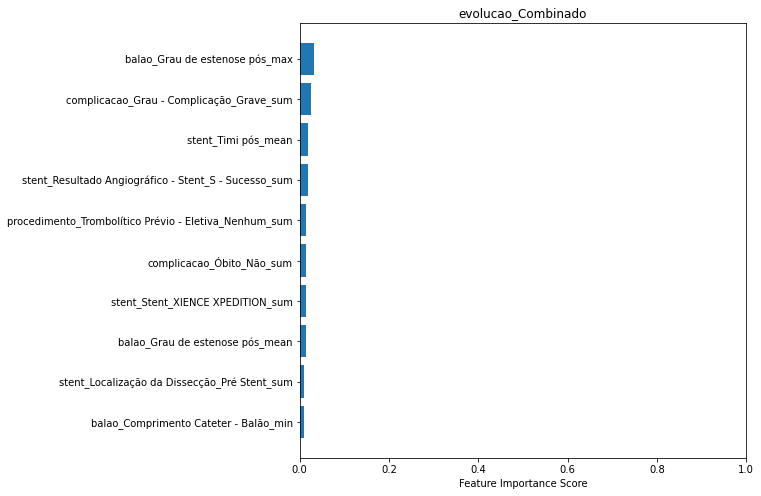


Predictions for  imputed_imbalanced_evolucao_Combinado_DecisionTree
Predicting on traning...imputed_imbalanced_evolucao_Combinado_DecisionTree
Value counts
0    5910
1     268
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 5910 fp: 0 fn: 0 tp: 268
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5910
           1       1.00      1.00      1.00       268

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...imputed_imbalanced_evolucao_Combinado_DecisionTree
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.9268608414239482
tn: 1416 fp: 60 fn: 53 tp: 16
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1476
           1       0.21      0.23      0.22        69

    accuracy        

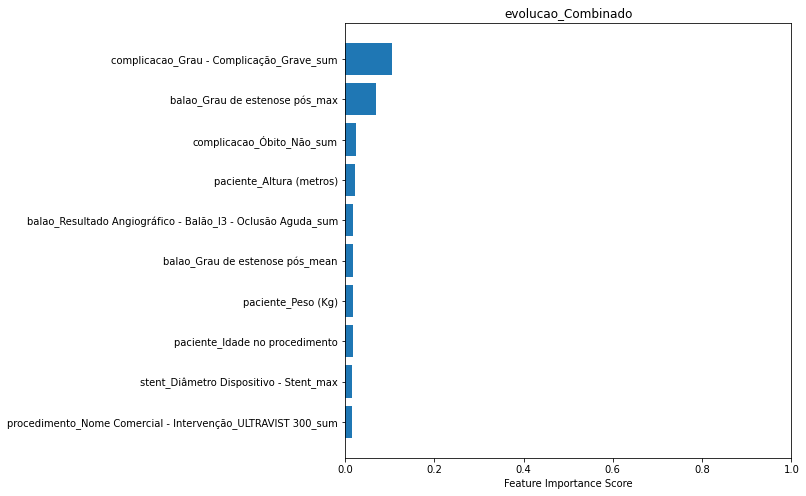


Predictions for  imputed_imbalanced_evolucao_Combinado_RandomForestClassifier
Predicting on traning...imputed_imbalanced_evolucao_Combinado_RandomForestClassifier
Value counts
0    5910
1     268
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 5910 fp: 0 fn: 0 tp: 268
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5910
           1       1.00      1.00      1.00       268

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...imputed_imbalanced_evolucao_Combinado_RandomForestClassifier
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.9585760517799353
tn: 1474 fp: 2 fn: 62 tp: 7
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1476
           1       0.78      0.10      0.18    

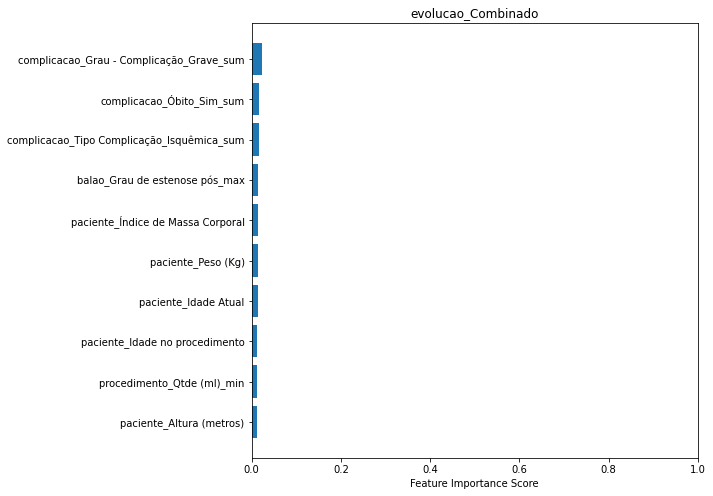


Predictions for  imputed_imbalanced_evolucao_Combinado_logistic
Predicting on traning...imputed_imbalanced_evolucao_Combinado_logistic
Value counts
0    5910
1     268
Name: evolucao_Combinado, dtype: int64
Score:  0.9580770475882162
tn: 5882 fp: 28 fn: 231 tp: 37
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5910
           1       0.57      0.14      0.22       268

    accuracy                           0.96      6178
   macro avg       0.77      0.57      0.60      6178
weighted avg       0.95      0.96      0.95      6178

True positive rate:  0.13805970149253732
Predicting on validation...imputed_imbalanced_evolucao_Combinado_logistic
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.9553398058252427
tn: 1466 fp: 10 fn: 59 tp: 10
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1476
           1       0.50      0.14      0.22        69


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_imbalanced_evolucao_Combinado_svm
Predicting on traning...imputed_imbalanced_evolucao_Combinado_svm
Value counts
0    5910
1     268
Name: evolucao_Combinado, dtype: int64
Score:  0.9569439948203302
tn: 5910 fp: 0 fn: 266 tp: 2
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5910
           1       1.00      0.01      0.01       268

    accuracy                           0.96      6178
   macro avg       0.98      0.50      0.50      6178
weighted avg       0.96      0.96      0.94      6178

True positive rate:  0.007462686567164179
Predicting on validation...imputed_imbalanced_evolucao_Combinado_svm
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.9553398058252427
tn: 1476 fp: 0 fn: 69 tp: 0
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1476
        

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC does not have feature_importances_ attribute

strategy RandomOverSampler
dataset label evolucao_Problema Clínico
Predictions for  imputed_RandomOverSampler_evolucao_Problema Clínico_XGBoost
Predicting on traning...imputed_RandomOverSampler_evolucao_Problema Clínico_XGBoost
Value counts
1    5938
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 5938 fp: 0 fn: 0 tp: 5938
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5938
           1       1.00      1.00      1.00      5938

    accuracy                           1.00     11876
   macro avg       1.00      1.00      1.00     11876
weighted avg       1.00      1.00      1.00     11876

True positive rate:  1.0
Predicting on validation...imputed_RandomOverSampler_evolucao_Problema Clínico_XGBoost
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9559870550161812
tn: 1460 fp: 21 fn: 47 tp: 17
              precision   

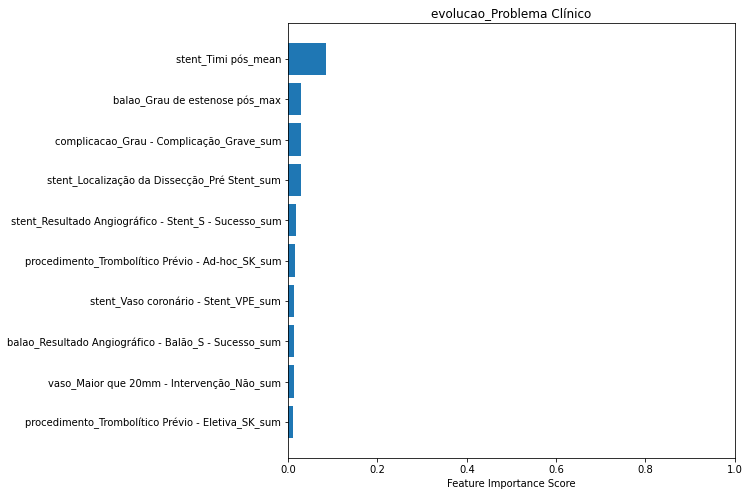


Predictions for  imputed_RandomOverSampler_evolucao_Problema Clínico_DecisionTree
Predicting on traning...imputed_RandomOverSampler_evolucao_Problema Clínico_DecisionTree
Value counts
1    5938
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 5938 fp: 0 fn: 0 tp: 5938
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5938
           1       1.00      1.00      1.00      5938

    accuracy                           1.00     11876
   macro avg       1.00      1.00      1.00     11876
weighted avg       1.00      1.00      1.00     11876

True positive rate:  1.0
Predicting on validation...imputed_RandomOverSampler_evolucao_Problema Clínico_DecisionTree
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9326860841423948
tn: 1427 fp: 54 fn: 50 tp: 14
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1481
           1      

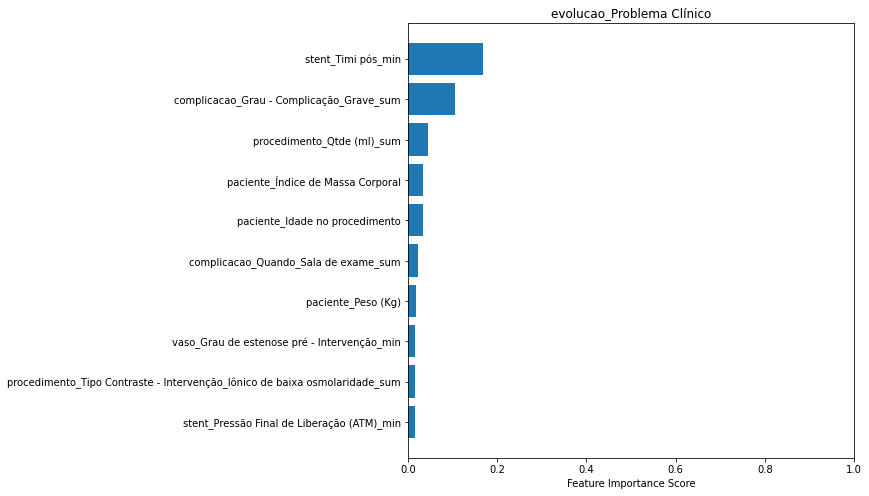


Predictions for  imputed_RandomOverSampler_evolucao_Problema Clínico_RandomForestClassifier
Predicting on traning...imputed_RandomOverSampler_evolucao_Problema Clínico_RandomForestClassifier
Value counts
1    5938
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 5938 fp: 0 fn: 0 tp: 5938
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5938
           1       1.00      1.00      1.00      5938

    accuracy                           1.00     11876
   macro avg       1.00      1.00      1.00     11876
weighted avg       1.00      1.00      1.00     11876

True positive rate:  1.0
Predicting on validation...imputed_RandomOverSampler_evolucao_Problema Clínico_RandomForestClassifier
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9631067961165048
tn: 1478 fp: 3 fn: 54 tp: 10
              precision    recall  f1-score   support

           0       0.96      1.00      0.98

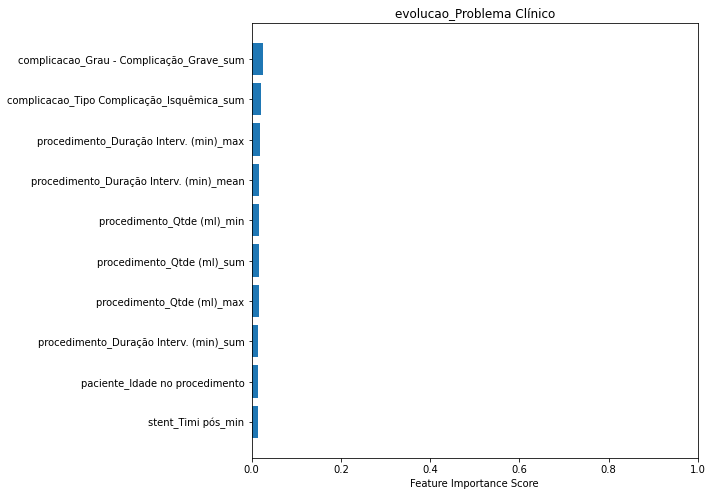


Predictions for  imputed_RandomOverSampler_evolucao_Problema Clínico_logistic
Predicting on traning...imputed_RandomOverSampler_evolucao_Problema Clínico_logistic
Value counts
1    5938
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.7578309195015157
tn: 4949 fp: 989 fn: 1887 tp: 4051
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      5938
           1       0.80      0.68      0.74      5938

    accuracy                           0.76     11876
   macro avg       0.76      0.76      0.76     11876
weighted avg       0.76      0.76      0.76     11876

True positive rate:  0.6822162344223645
Predicting on validation...imputed_RandomOverSampler_evolucao_Problema Clínico_logistic
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.8097087378640777
tn: 1214 fp: 267 fn: 27 tp: 37
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_RandomOverSampler_evolucao_Problema Clínico_svm
Predicting on traning...imputed_RandomOverSampler_evolucao_Problema Clínico_svm
Value counts
1    5938
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.7486527450319973
tn: 5219 fp: 719 fn: 2266 tp: 3672
              precision    recall  f1-score   support

           0       0.70      0.88      0.78      5938
           1       0.84      0.62      0.71      5938

    accuracy                           0.75     11876
   macro avg       0.77      0.75      0.74     11876
weighted avg       0.77      0.75      0.74     11876

True positive rate:  0.6183900303132368
Predicting on validation...imputed_RandomOverSampler_evolucao_Problema Clínico_svm
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.8601941747572815
tn: 1298 fp: 183 fn: 33 tp: 31
              precision    recall  f1-score   support


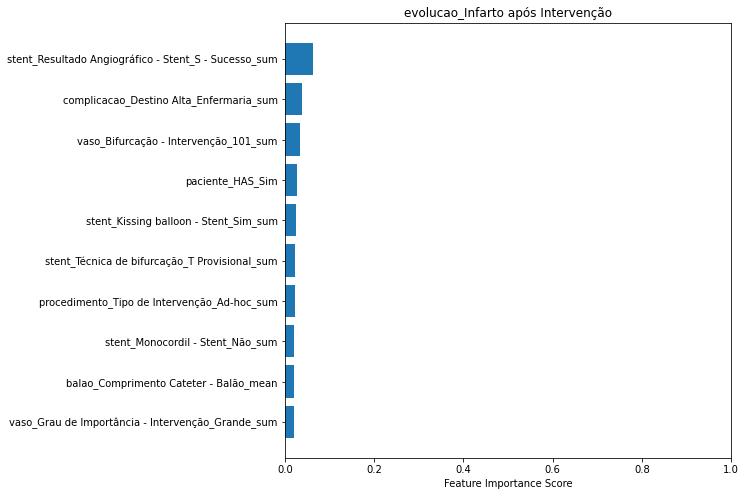


Predictions for  imputed_RandomOverSampler_evolucao_Infarto após Intervenção_DecisionTree
Predicting on traning...imputed_RandomOverSampler_evolucao_Infarto após Intervenção_DecisionTree
Value counts
1    6064
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 6064
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00      6064

    accuracy                           1.00     12128
   macro avg       1.00      1.00      1.00     12128
weighted avg       1.00      1.00      1.00     12128

True positive rate:  1.0
Predicting on validation...imputed_RandomOverSampler_evolucao_Infarto após Intervenção_DecisionTree
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9553398058252427
tn: 1476 fp: 29 fn: 40 tp: 0
              precision    recall  f1-score   support

           0       0.97      0.98

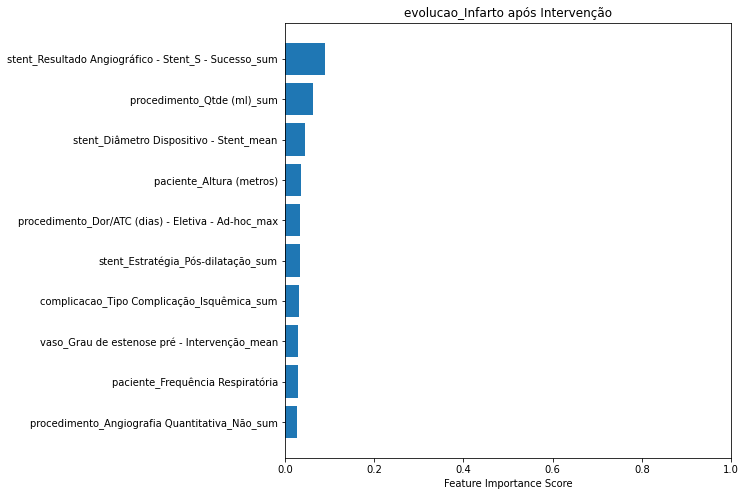


Predictions for  imputed_RandomOverSampler_evolucao_Infarto após Intervenção_RandomForestClassifier
Predicting on traning...imputed_RandomOverSampler_evolucao_Infarto após Intervenção_RandomForestClassifier
Value counts
1    6064
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 6064
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00      6064

    accuracy                           1.00     12128
   macro avg       1.00      1.00      1.00     12128
weighted avg       1.00      1.00      1.00     12128

True positive rate:  1.0
Predicting on validation...imputed_RandomOverSampler_evolucao_Infarto após Intervenção_RandomForestClassifier
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9741100323624595
tn: 1505 fp: 0 fn: 40 tp: 0
              precision    recall  f1-score   support

    

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


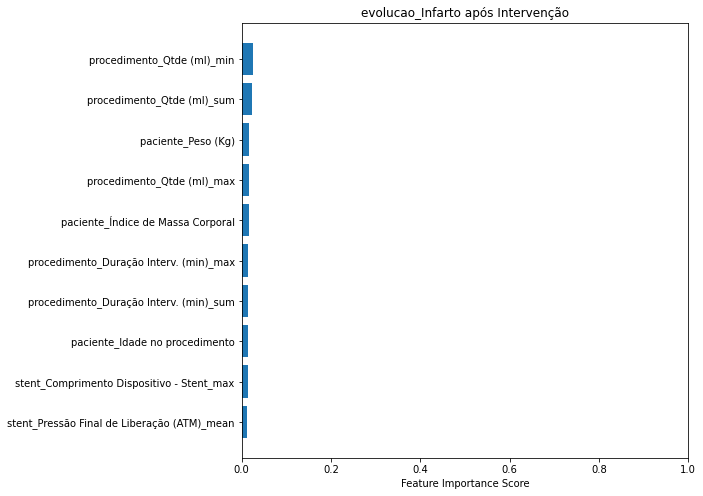


Predictions for  imputed_RandomOverSampler_evolucao_Infarto após Intervenção_logistic
Predicting on traning...imputed_RandomOverSampler_evolucao_Infarto após Intervenção_logistic
Value counts
1    6064
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7111642480211082
tn: 4634 fp: 1430 fn: 2073 tp: 3991
              precision    recall  f1-score   support

           0       0.69      0.76      0.73      6064
           1       0.74      0.66      0.69      6064

    accuracy                           0.71     12128
   macro avg       0.71      0.71      0.71     12128
weighted avg       0.71      0.71      0.71     12128

True positive rate:  0.6581464379947229
Predicting on validation...imputed_RandomOverSampler_evolucao_Infarto após Intervenção_logistic
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7650485436893204
tn: 1162 fp: 343 fn: 20 tp: 20
              precision    recall  f1-score   support

       

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_RandomOverSampler_evolucao_Infarto após Intervenção_svm
Predicting on traning...imputed_RandomOverSampler_evolucao_Infarto após Intervenção_svm
Value counts
1    6064
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7472790237467019
tn: 4779 fp: 1285 fn: 1780 tp: 4284
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      6064
           1       0.77      0.71      0.74      6064

    accuracy                           0.75     12128
   macro avg       0.75      0.75      0.75     12128
weighted avg       0.75      0.75      0.75     12128

True positive rate:  0.7064643799472295
Predicting on validation...imputed_RandomOverSampler_evolucao_Infarto após Intervenção_svm
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7734627831715211
tn: 1174 fp: 331 fn: 19 tp: 21
             

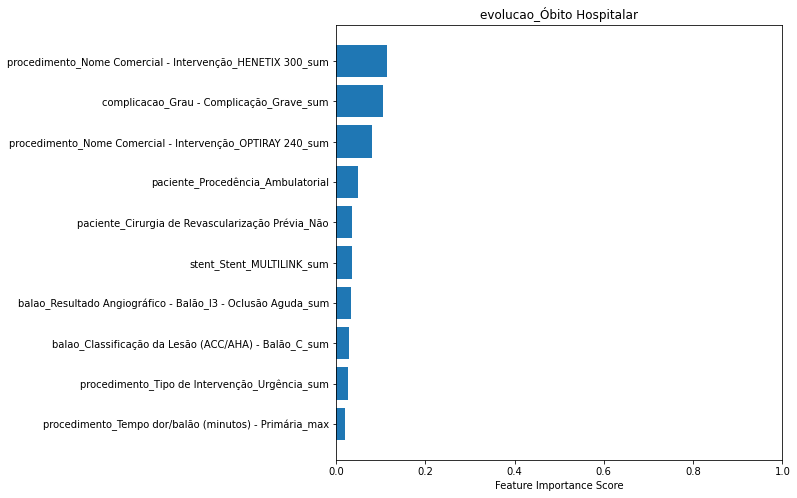


Predictions for  imputed_RandomOverSampler_evolucao_Óbito Hospitalar_DecisionTree
Predicting on traning...imputed_RandomOverSampler_evolucao_Óbito Hospitalar_DecisionTree
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6096

    accuracy                           1.00     12192
   macro avg       1.00      1.00      1.00     12192
weighted avg       1.00      1.00      1.00     12192

True positive rate:  1.0
Predicting on validation...imputed_RandomOverSampler_evolucao_Óbito Hospitalar_DecisionTree
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9864077669902913
tn: 1520 fp: 14 fn: 7 tp: 4
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1534
           1       0

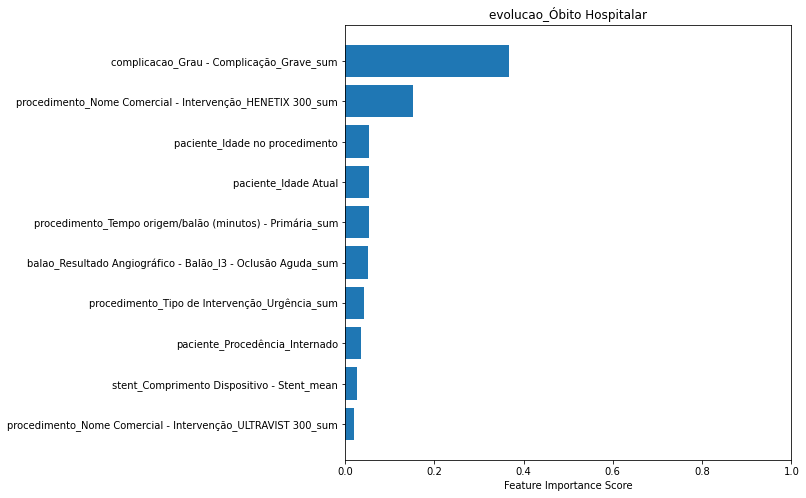


Predictions for  imputed_RandomOverSampler_evolucao_Óbito Hospitalar_RandomForestClassifier
Predicting on traning...imputed_RandomOverSampler_evolucao_Óbito Hospitalar_RandomForestClassifier
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6096

    accuracy                           1.00     12192
   macro avg       1.00      1.00      1.00     12192
weighted avg       1.00      1.00      1.00     12192

True positive rate:  1.0
Predicting on validation...imputed_RandomOverSampler_evolucao_Óbito Hospitalar_RandomForestClassifier
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9928802588996763
tn: 1534 fp: 0 fn: 11 tp: 0
              precision    recall  f1-score   support

           0       0.99      1.00      1.00 

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


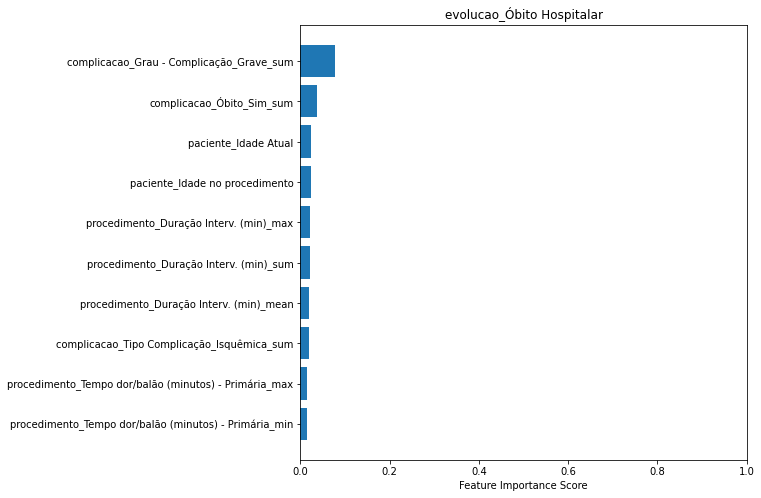


Predictions for  imputed_RandomOverSampler_evolucao_Óbito Hospitalar_logistic
Predicting on traning...imputed_RandomOverSampler_evolucao_Óbito Hospitalar_logistic
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.83374343832021
tn: 5210 fp: 886 fn: 1141 tp: 4955
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      6096
           1       0.85      0.81      0.83      6096

    accuracy                           0.83     12192
   macro avg       0.83      0.83      0.83     12192
weighted avg       0.83      0.83      0.83     12192

True positive rate:  0.8128280839895013
Predicting on validation...imputed_RandomOverSampler_evolucao_Óbito Hospitalar_logistic
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8621359223300971
tn: 1324 fp: 210 fn: 3 tp: 8
              precision    recall  f1-score   support

           0       1.00      0.86      0.93      153

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_RandomOverSampler_evolucao_Óbito Hospitalar_svm
Predicting on traning...imputed_RandomOverSampler_evolucao_Óbito Hospitalar_svm
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8368602362204725
tn: 5421 fp: 675 fn: 1314 tp: 4782
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      6096
           1       0.88      0.78      0.83      6096

    accuracy                           0.84     12192
   macro avg       0.84      0.84      0.84     12192
weighted avg       0.84      0.84      0.84     12192

True positive rate:  0.7844488188976378
Predicting on validation...imputed_RandomOverSampler_evolucao_Óbito Hospitalar_svm
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8705501618122977
tn: 1341 fp: 193 fn: 7 tp: 4
              precision    recall  f1-score   support

 

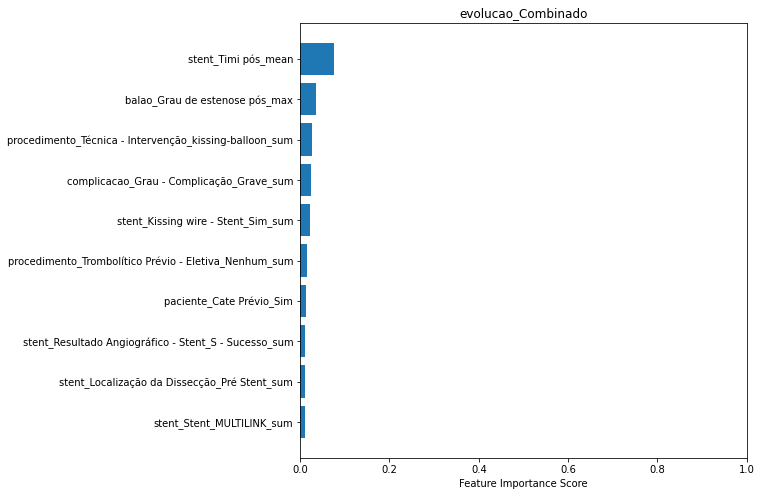


Predictions for  imputed_RandomOverSampler_evolucao_Combinado_DecisionTree
Predicting on traning...imputed_RandomOverSampler_evolucao_Combinado_DecisionTree
Value counts
1    5910
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 5910 fp: 0 fn: 0 tp: 5910
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5910
           1       1.00      1.00      1.00      5910

    accuracy                           1.00     11820
   macro avg       1.00      1.00      1.00     11820
weighted avg       1.00      1.00      1.00     11820

True positive rate:  1.0
Predicting on validation...imputed_RandomOverSampler_evolucao_Combinado_DecisionTree
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.911326860841424
tn: 1394 fp: 82 fn: 55 tp: 14
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1476
           1       0.15      0.20      0.17        69


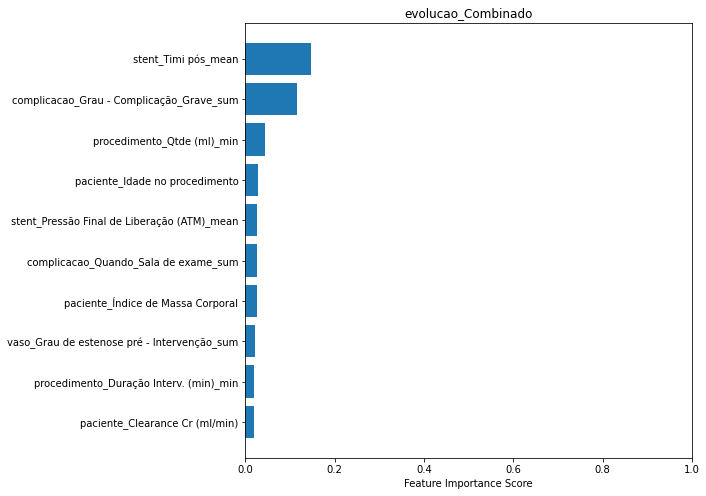


Predictions for  imputed_RandomOverSampler_evolucao_Combinado_RandomForestClassifier
Predicting on traning...imputed_RandomOverSampler_evolucao_Combinado_RandomForestClassifier
Value counts
1    5910
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 5910 fp: 0 fn: 0 tp: 5910
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5910
           1       1.00      1.00      1.00      5910

    accuracy                           1.00     11820
   macro avg       1.00      1.00      1.00     11820
weighted avg       1.00      1.00      1.00     11820

True positive rate:  1.0
Predicting on validation...imputed_RandomOverSampler_evolucao_Combinado_RandomForestClassifier
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.9585760517799353
tn: 1467 fp: 9 fn: 55 tp: 14
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1476
           1       0.61 

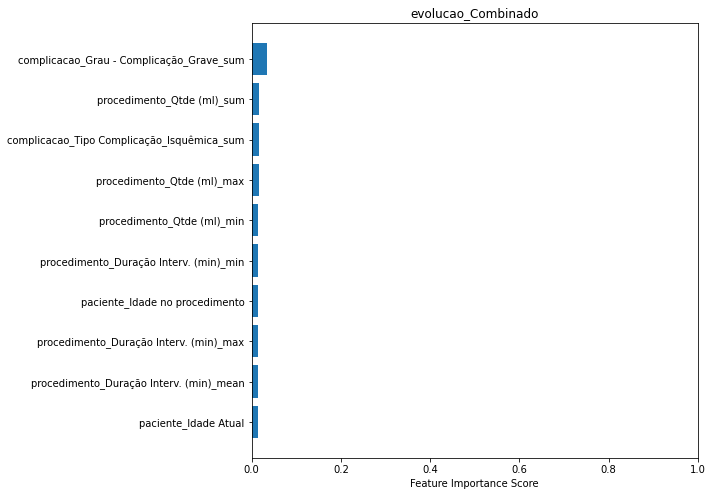


Predictions for  imputed_RandomOverSampler_evolucao_Combinado_logistic
Predicting on traning...imputed_RandomOverSampler_evolucao_Combinado_logistic
Value counts
1    5910
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  0.7408629441624366
tn: 4863 fp: 1047 fn: 2016 tp: 3894
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      5910
           1       0.79      0.66      0.72      5910

    accuracy                           0.74     11820
   macro avg       0.75      0.74      0.74     11820
weighted avg       0.75      0.74      0.74     11820

True positive rate:  0.6588832487309645
Predicting on validation...imputed_RandomOverSampler_evolucao_Combinado_logistic
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.7954692556634304
tn: 1195 fp: 281 fn: 35 tp: 34
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1476
           1       0.11     

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_RandomOverSampler_evolucao_Combinado_svm
Predicting on traning...imputed_RandomOverSampler_evolucao_Combinado_svm
Value counts
1    5910
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  0.7377326565143824
tn: 5066 fp: 844 fn: 2256 tp: 3654
              precision    recall  f1-score   support

           0       0.69      0.86      0.77      5910
           1       0.81      0.62      0.70      5910

    accuracy                           0.74     11820
   macro avg       0.75      0.74      0.73     11820
weighted avg       0.75      0.74      0.73     11820

True positive rate:  0.6182741116751269
Predicting on validation...imputed_RandomOverSampler_evolucao_Combinado_svm
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.8381877022653722
tn: 1260 fp: 216 fn: 34 tp: 35
              precision    recall  f1-score   support

           0       0.97      0.85 

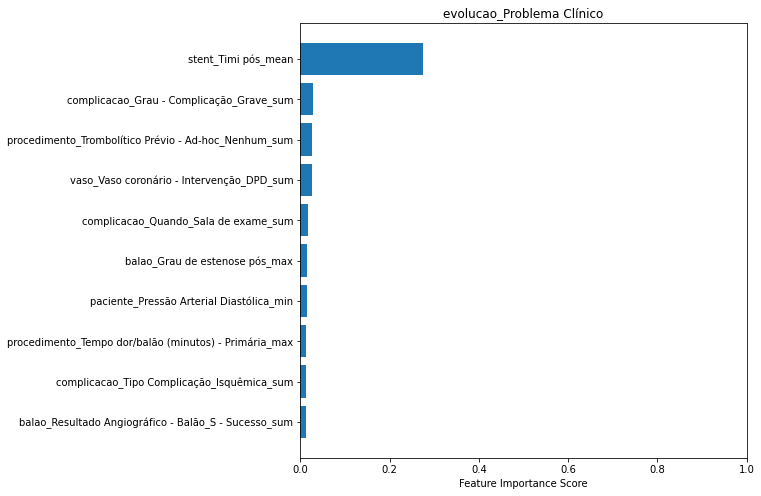


Predictions for  imputed_RandomUnderSampler_evolucao_Problema Clínico_DecisionTree
Predicting on traning...imputed_RandomUnderSampler_evolucao_Problema Clínico_DecisionTree
Value counts
1    240
0    240
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 240 fp: 0 fn: 0 tp: 240
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       240

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

True positive rate:  1.0
Predicting on validation...imputed_RandomUnderSampler_evolucao_Problema Clínico_DecisionTree
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.6796116504854369
tn: 1006 fp: 475 fn: 20 tp: 44
              precision    recall  f1-score   support

           0       0.98      0.68      0.80      1481
           1      

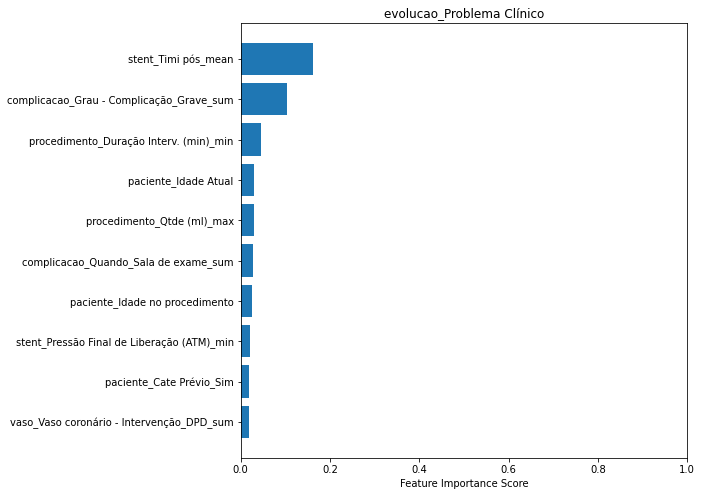


Predictions for  imputed_RandomUnderSampler_evolucao_Problema Clínico_RandomForestClassifier
Predicting on traning...imputed_RandomUnderSampler_evolucao_Problema Clínico_RandomForestClassifier
Value counts
1    240
0    240
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 240 fp: 0 fn: 0 tp: 240
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       240

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

True positive rate:  1.0
Predicting on validation...imputed_RandomUnderSampler_evolucao_Problema Clínico_RandomForestClassifier
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.8161812297734627
tn: 1217 fp: 264 fn: 20 tp: 44
              precision    recall  f1-score   support

           0       0.98      0.82      0.9

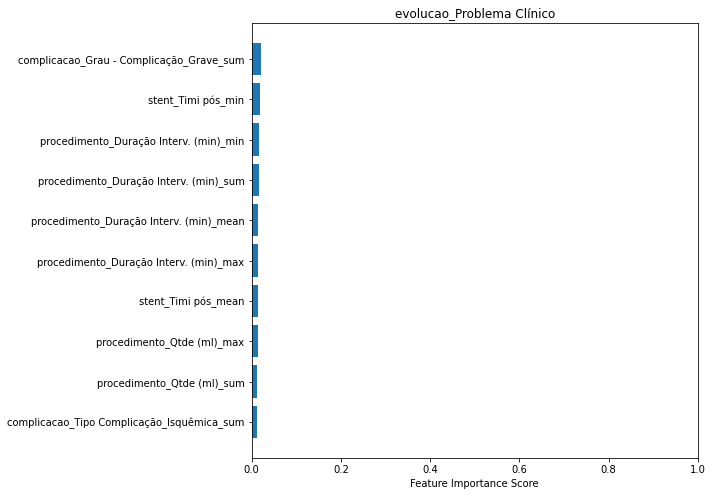


Predictions for  imputed_RandomUnderSampler_evolucao_Problema Clínico_logistic
Predicting on traning...imputed_RandomUnderSampler_evolucao_Problema Clínico_logistic
Value counts
1    240
0    240
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.7520833333333333
tn: 196 fp: 44 fn: 75 tp: 165
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       240
           1       0.79      0.69      0.73       240

    accuracy                           0.75       480
   macro avg       0.76      0.75      0.75       480
weighted avg       0.76      0.75      0.75       480

True positive rate:  0.6875
Predicting on validation...imputed_RandomUnderSampler_evolucao_Problema Clínico_logistic
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.7715210355987056
tn: 1159 fp: 322 fn: 31 tp: 33
              precision    recall  f1-score   support

           0       0.97      0.78      0.87      1481
          

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Score:  0.6958333333333333
tn: 199 fp: 41 fn: 105 tp: 135
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       240
           1       0.77      0.56      0.65       240

    accuracy                           0.70       480
   macro avg       0.71      0.70      0.69       480
weighted avg       0.71      0.70      0.69       480

True positive rate:  0.5625
Predicting on validation...imputed_RandomUnderSampler_evolucao_Problema Clínico_svm
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.8401294498381877
tn: 1268 fp: 213 fn: 34 tp: 30
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1481
           1       0.12      0.47      0.20        64

    accuracy                           0.84      1545
   macro avg       0.55      0.66      0.55      1545
weighted avg       0.94      0.84      0.88      1545

True positive rate:  0.46875
SVC does n

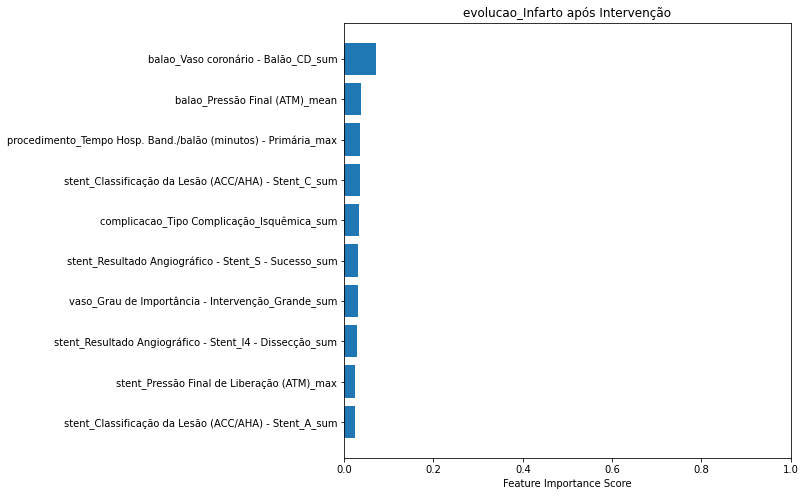


Predictions for  imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_DecisionTree
Predicting on traning...imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_DecisionTree
Value counts
1    114
0    114
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 114 fp: 0 fn: 0 tp: 114
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00       114

    accuracy                           1.00       228
   macro avg       1.00      1.00      1.00       228
weighted avg       1.00      1.00      1.00       228

True positive rate:  1.0
Predicting on validation...imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_DecisionTree
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.5605177993527508
tn: 845 fp: 660 fn: 19 tp: 21
              precision    recall  f1-score   support

           0       0.98      0.56

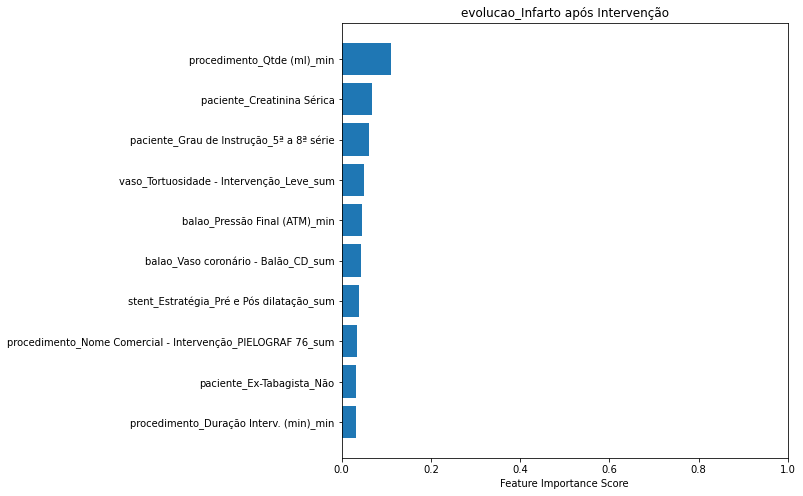


Predictions for  imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_RandomForestClassifier
Predicting on traning...imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_RandomForestClassifier
Value counts
1    114
0    114
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 114 fp: 0 fn: 0 tp: 114
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00       114

    accuracy                           1.00       228
   macro avg       1.00      1.00      1.00       228
weighted avg       1.00      1.00      1.00       228

True positive rate:  1.0
Predicting on validation...imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_RandomForestClassifier
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7132686084142394
tn: 1081 fp: 424 fn: 19 tp: 21
              precision    recall  f1-score   support

  

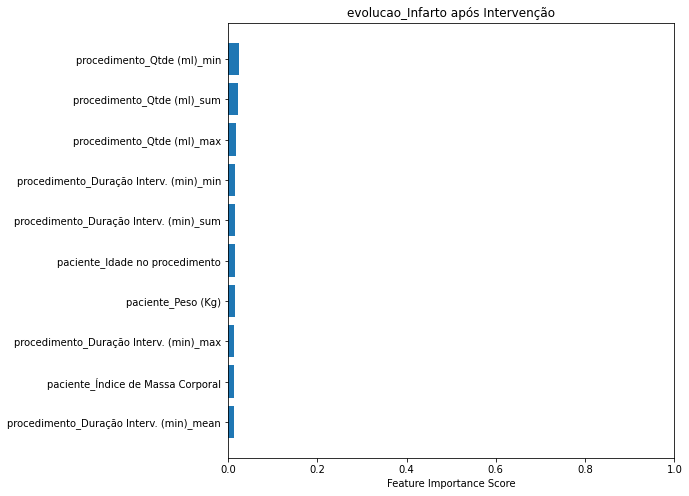


Predictions for  imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_logistic
Predicting on traning...imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_logistic
Value counts
1    114
0    114
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7587719298245614
tn: 88 fp: 26 fn: 29 tp: 85
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       114
           1       0.77      0.75      0.76       114

    accuracy                           0.76       228
   macro avg       0.76      0.76      0.76       228
weighted avg       0.76      0.76      0.76       228

True positive rate:  0.7456140350877193
Predicting on validation...imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_logistic
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.6627831715210356
tn: 1004 fp: 501 fn: 20 tp: 20
              precision    recall  f1-score   support

           0  

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Score:  0.6535087719298246
tn: 102 fp: 12 fn: 67 tp: 47
              precision    recall  f1-score   support

           0       0.60      0.89      0.72       114
           1       0.80      0.41      0.54       114

    accuracy                           0.65       228
   macro avg       0.70      0.65      0.63       228
weighted avg       0.70      0.65      0.63       228

True positive rate:  0.41228070175438597
Predicting on validation...imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_svm
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.8427184466019417
tn: 1285 fp: 220 fn: 23 tp: 17
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1505
           1       0.07      0.42      0.12        40

    accuracy                           0.84      1545
   macro avg       0.53      0.64      0.52      1545
weighted avg       0.96      0.84      0.89      1545

True positiv

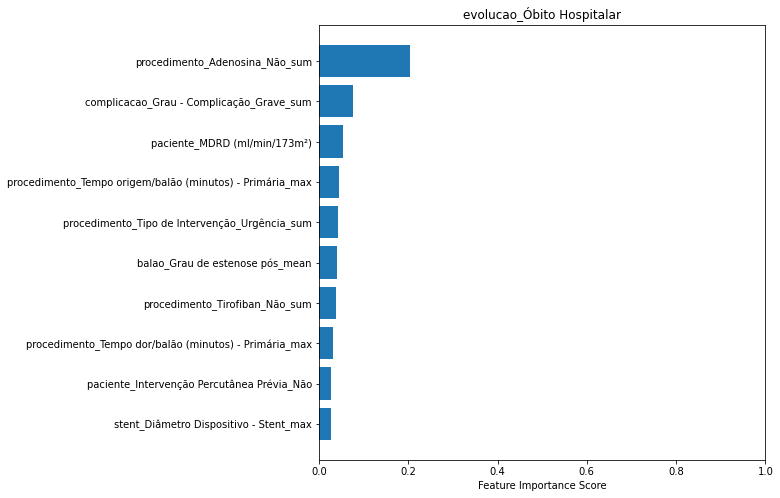


Predictions for  imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_DecisionTree
Predicting on traning...imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_DecisionTree
Value counts
1    82
0    82
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 82 fp: 0 fn: 0 tp: 82
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        82

    accuracy                           1.00       164
   macro avg       1.00      1.00      1.00       164
weighted avg       1.00      1.00      1.00       164

True positive rate:  1.0
Predicting on validation...imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_DecisionTree
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8407766990291262
tn: 1292 fp: 242 fn: 4 tp: 7
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1534
           1       0.03 

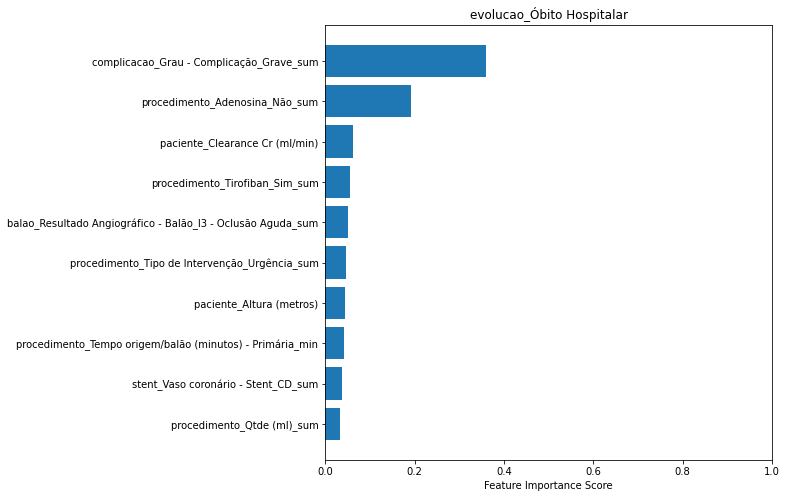


Predictions for  imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_RandomForestClassifier
Predicting on traning...imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_RandomForestClassifier
Value counts
1    82
0    82
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 82 fp: 0 fn: 0 tp: 82
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        82

    accuracy                           1.00       164
   macro avg       1.00      1.00      1.00       164
weighted avg       1.00      1.00      1.00       164

True positive rate:  1.0
Predicting on validation...imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_RandomForestClassifier
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8640776699029126
tn: 1326 fp: 208 fn: 2 tp: 9
              precision    recall  f1-score   support

           0       1.00      0.86      0.93     

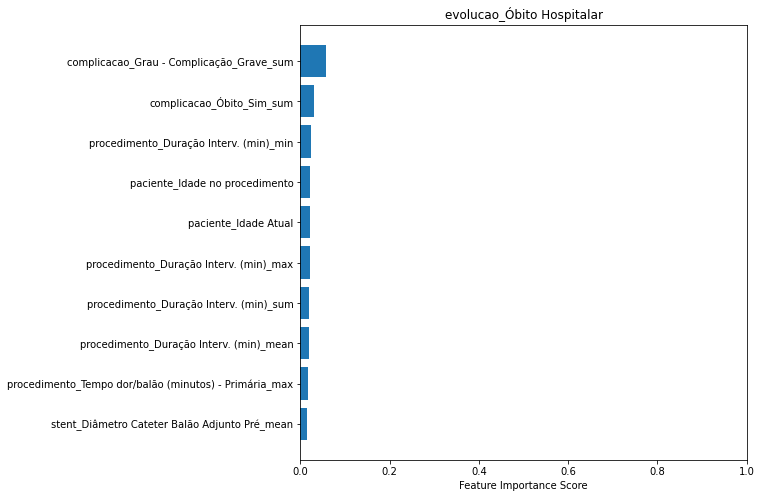


Predictions for  imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_logistic
Predicting on traning...imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_logistic
Value counts
1    82
0    82
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8597560975609756
tn: 72 fp: 10 fn: 13 tp: 69
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        82
           1       0.87      0.84      0.86        82

    accuracy                           0.86       164
   macro avg       0.86      0.86      0.86       164
weighted avg       0.86      0.86      0.86       164

True positive rate:  0.8414634146341463
Predicting on validation...imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_logistic
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.7469255663430421
tn: 1145 fp: 389 fn: 2 tp: 9
              precision    recall  f1-score   support

           0       1.00      0.75      0.85      1534
    

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Score:  0.7439024390243902
tn: 71 fp: 11 fn: 31 tp: 51
              precision    recall  f1-score   support

           0       0.70      0.87      0.77        82
           1       0.82      0.62      0.71        82

    accuracy                           0.74       164
   macro avg       0.76      0.74      0.74       164
weighted avg       0.76      0.74      0.74       164

True positive rate:  0.6219512195121951
Predicting on validation...imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_svm
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.856957928802589
tn: 1318 fp: 216 fn: 5 tp: 6
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      1534
           1       0.03      0.55      0.05        11

    accuracy                           0.86      1545
   macro avg       0.51      0.70      0.49      1545
weighted avg       0.99      0.86      0.92      1545

True positive rate:  0.5454545454

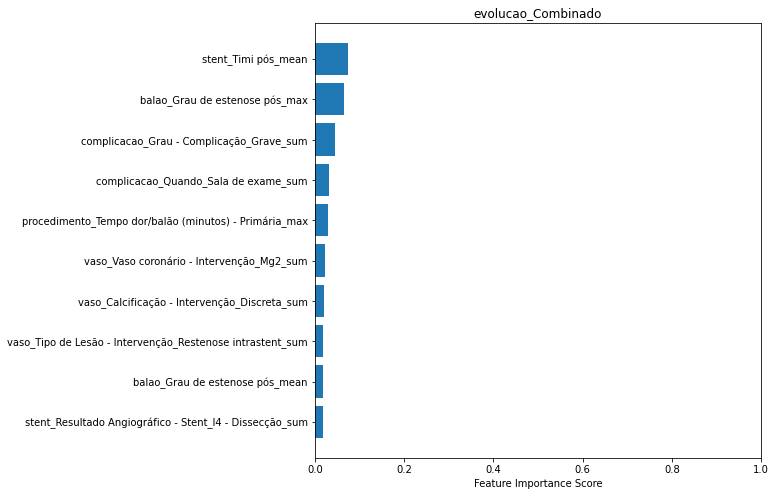


Predictions for  imputed_RandomUnderSampler_evolucao_Combinado_DecisionTree
Predicting on traning...imputed_RandomUnderSampler_evolucao_Combinado_DecisionTree
Value counts
1    268
0    268
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 268 fp: 0 fn: 0 tp: 268
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       268
           1       1.00      1.00      1.00       268

    accuracy                           1.00       536
   macro avg       1.00      1.00      1.00       536
weighted avg       1.00      1.00      1.00       536

True positive rate:  1.0
Predicting on validation...imputed_RandomUnderSampler_evolucao_Combinado_DecisionTree
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.6537216828478964
tn: 968 fp: 508 fn: 27 tp: 42
              precision    recall  f1-score   support

           0       0.97      0.66      0.78      1476
           1       0.08      0.61      0.14        69


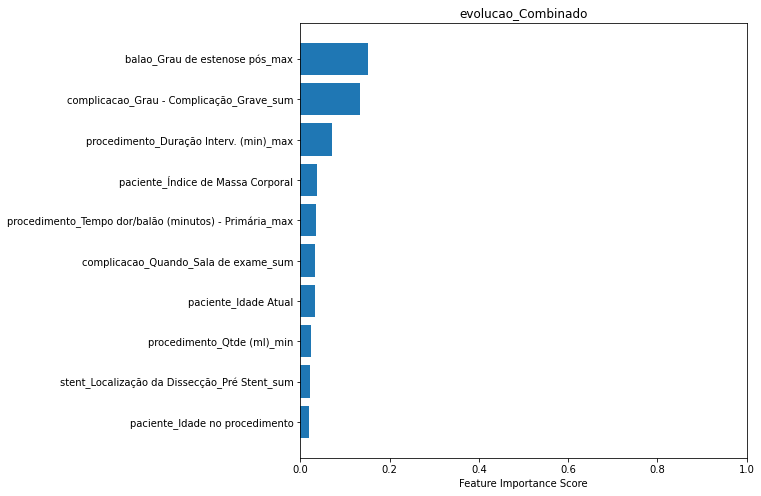


Predictions for  imputed_RandomUnderSampler_evolucao_Combinado_RandomForestClassifier
Predicting on traning...imputed_RandomUnderSampler_evolucao_Combinado_RandomForestClassifier
Value counts
1    268
0    268
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 268 fp: 0 fn: 0 tp: 268
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       268
           1       1.00      1.00      1.00       268

    accuracy                           1.00       536
   macro avg       1.00      1.00      1.00       536
weighted avg       1.00      1.00      1.00       536

True positive rate:  1.0
Predicting on validation...imputed_RandomUnderSampler_evolucao_Combinado_RandomForestClassifier
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.7378640776699029
tn: 1093 fp: 383 fn: 22 tp: 47
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1476
           1       0.11

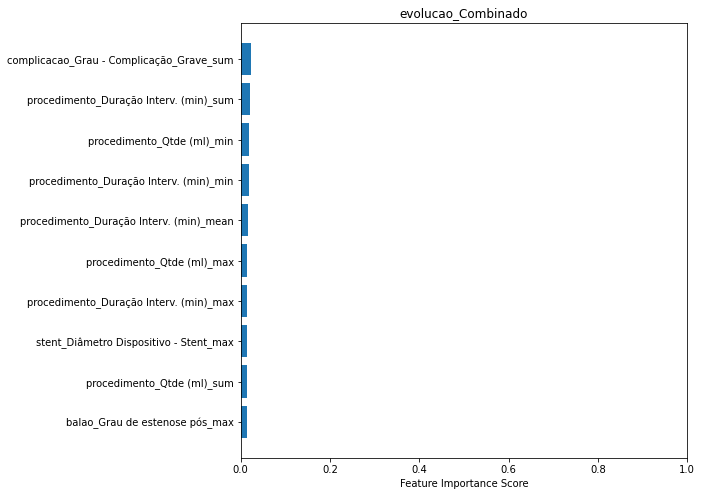


Predictions for  imputed_RandomUnderSampler_evolucao_Combinado_logistic
Predicting on traning...imputed_RandomUnderSampler_evolucao_Combinado_logistic
Value counts
1    268
0    268
Name: evolucao_Combinado, dtype: int64
Score:  0.7574626865671642
tn: 223 fp: 45 fn: 85 tp: 183
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       268
           1       0.80      0.68      0.74       268

    accuracy                           0.76       536
   macro avg       0.76      0.76      0.76       536
weighted avg       0.76      0.76      0.76       536

True positive rate:  0.6828358208955224
Predicting on validation...imputed_RandomUnderSampler_evolucao_Combinado_logistic
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.7404530744336569
tn: 1102 fp: 374 fn: 27 tp: 42
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1476
           1       0.10      0.61

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_RandomUnderSampler_evolucao_Combinado_svm
Predicting on traning...imputed_RandomUnderSampler_evolucao_Combinado_svm
Value counts
1    268
0    268
Name: evolucao_Combinado, dtype: int64
Score:  0.7294776119402985
tn: 240 fp: 28 fn: 117 tp: 151
              precision    recall  f1-score   support

           0       0.67      0.90      0.77       268
           1       0.84      0.56      0.68       268

    accuracy                           0.73       536
   macro avg       0.76      0.73      0.72       536
weighted avg       0.76      0.73      0.72       536

True positive rate:  0.5634328358208955
Predicting on validation...imputed_RandomUnderSampler_evolucao_Combinado_svm
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.829126213592233
tn: 1249 fp: 227 fn: 37 tp: 32
              precision    recall  f1-score   support

           0       0.97      0.85     

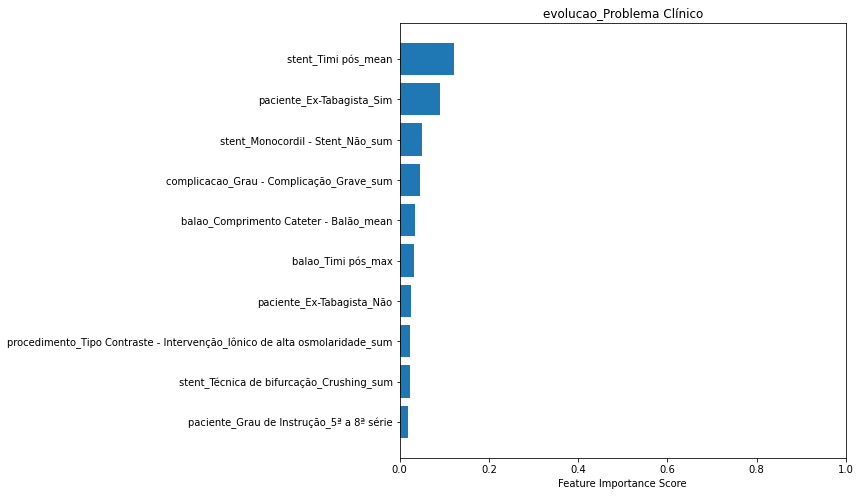


Predictions for  imputed_ADASYN_evolucao_Problema Clínico_DecisionTree
Predicting on traning...imputed_ADASYN_evolucao_Problema Clínico_DecisionTree
Value counts
1    5952
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 5938 fp: 0 fn: 0 tp: 5952
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5938
           1       1.00      1.00      1.00      5952

    accuracy                           1.00     11890
   macro avg       1.00      1.00      1.00     11890
weighted avg       1.00      1.00      1.00     11890

True positive rate:  1.0
Predicting on validation...imputed_ADASYN_evolucao_Problema Clínico_DecisionTree
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9326860841423948
tn: 1425 fp: 56 fn: 48 tp: 16
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1481
           1       0.22      0.25      0.24        

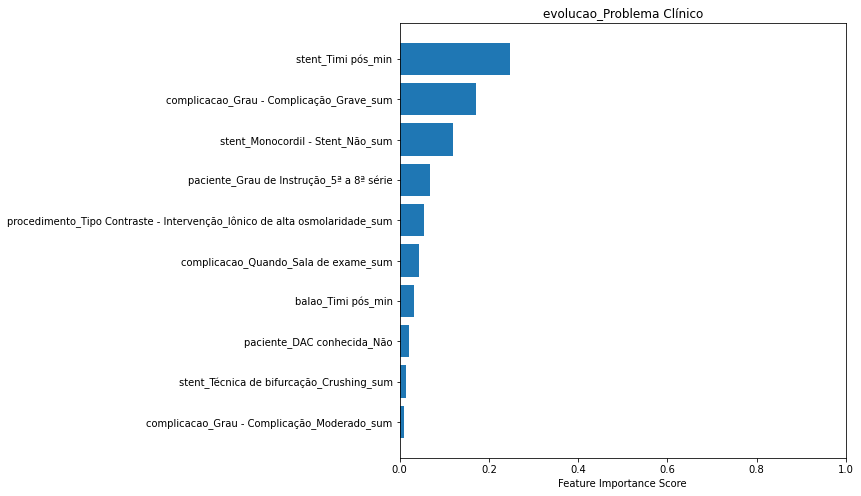


Predictions for  imputed_ADASYN_evolucao_Problema Clínico_RandomForestClassifier
Predicting on traning...imputed_ADASYN_evolucao_Problema Clínico_RandomForestClassifier
Value counts
1    5952
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 5938 fp: 0 fn: 0 tp: 5952
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5938
           1       1.00      1.00      1.00      5952

    accuracy                           1.00     11890
   macro avg       1.00      1.00      1.00     11890
weighted avg       1.00      1.00      1.00     11890

True positive rate:  1.0
Predicting on validation...imputed_ADASYN_evolucao_Problema Clínico_RandomForestClassifier
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9579288025889967
tn: 1475 fp: 6 fn: 59 tp: 5
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1481
           1       0.45

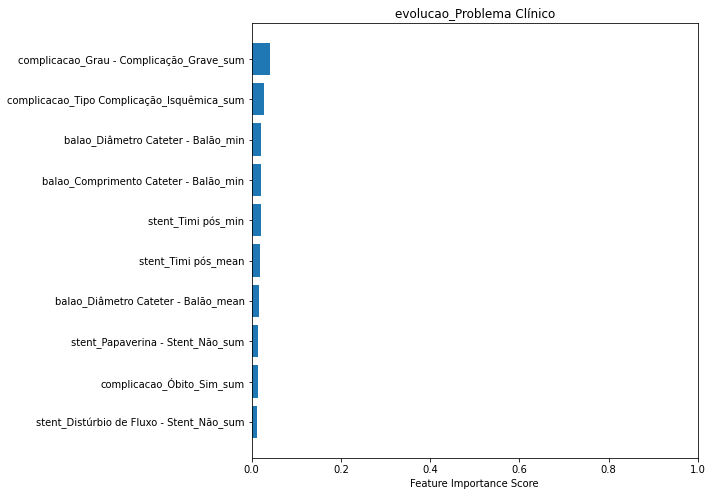


Predictions for  imputed_ADASYN_evolucao_Problema Clínico_logistic
Predicting on traning...imputed_ADASYN_evolucao_Problema Clínico_logistic
Value counts
1    5952
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.7459209419680404
tn: 4760 fp: 1178 fn: 1843 tp: 4109
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      5938
           1       0.78      0.69      0.73      5952

    accuracy                           0.75     11890
   macro avg       0.75      0.75      0.75     11890
weighted avg       0.75      0.75      0.75     11890

True positive rate:  0.6903561827956989
Predicting on validation...imputed_ADASYN_evolucao_Problema Clínico_logistic
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.7877022653721683
tn: 1178 fp: 303 fn: 25 tp: 39
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      1481
           1       0.11   

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_ADASYN_evolucao_Problema Clínico_svm
Predicting on traning...imputed_ADASYN_evolucao_Problema Clínico_svm
Value counts
1    5952
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.7328006728343146
tn: 5068 fp: 870 fn: 2307 tp: 3645
              precision    recall  f1-score   support

           0       0.69      0.85      0.76      5938
           1       0.81      0.61      0.70      5952

    accuracy                           0.73     11890
   macro avg       0.75      0.73      0.73     11890
weighted avg       0.75      0.73      0.73     11890

True positive rate:  0.6123991935483871
Predicting on validation...imputed_ADASYN_evolucao_Problema Clínico_svm
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.8355987055016181
tn: 1258 fp: 223 fn: 31 tp: 33
              precision    recall  f1-score   support

           0       0.98      0.8

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


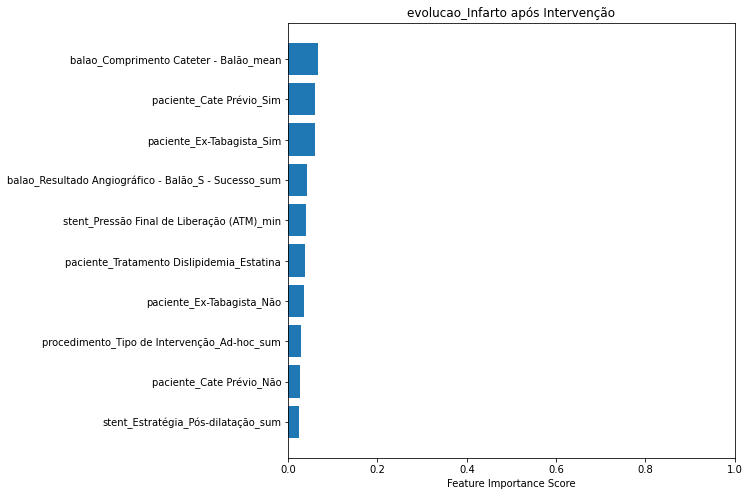


Predictions for  imputed_ADASYN_evolucao_Infarto após Intervenção_DecisionTree
Predicting on traning...imputed_ADASYN_evolucao_Infarto após Intervenção_DecisionTree
Value counts
0    6064
1    6032
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 6032
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00      6032

    accuracy                           1.00     12096
   macro avg       1.00      1.00      1.00     12096
weighted avg       1.00      1.00      1.00     12096

True positive rate:  1.0
Predicting on validation...imputed_ADASYN_evolucao_Infarto após Intervenção_DecisionTree
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9566343042071197
tn: 1474 fp: 31 fn: 36 tp: 4
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1505
           1

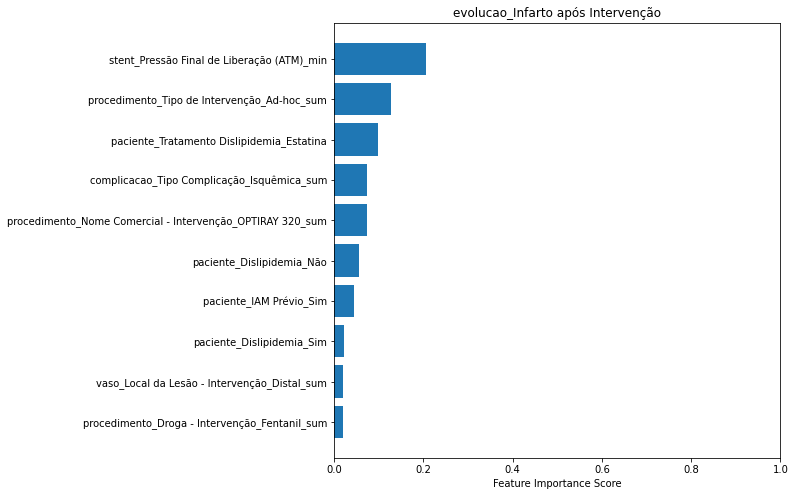


Predictions for  imputed_ADASYN_evolucao_Infarto após Intervenção_RandomForestClassifier
Predicting on traning...imputed_ADASYN_evolucao_Infarto após Intervenção_RandomForestClassifier
Value counts
0    6064
1    6032
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 6032
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00      6032

    accuracy                           1.00     12096
   macro avg       1.00      1.00      1.00     12096
weighted avg       1.00      1.00      1.00     12096

True positive rate:  1.0
Predicting on validation...imputed_ADASYN_evolucao_Infarto após Intervenção_RandomForestClassifier
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9741100323624595
tn: 1505 fp: 0 fn: 40 tp: 0
              precision    recall  f1-score   support

           0       0.97      1.00    

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


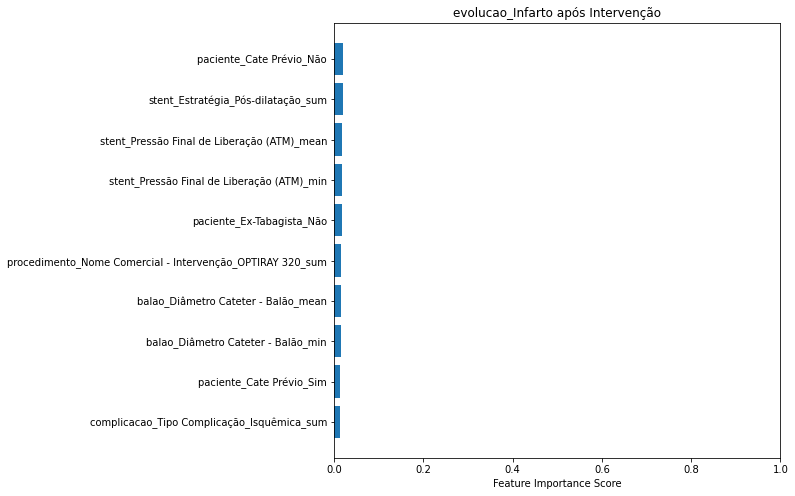


Predictions for  imputed_ADASYN_evolucao_Infarto após Intervenção_logistic
Predicting on traning...imputed_ADASYN_evolucao_Infarto após Intervenção_logistic
Value counts
0    6064
1    6032
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7318121693121693
tn: 4604 fp: 1460 fn: 1784 tp: 4248
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      6064
           1       0.74      0.70      0.72      6032

    accuracy                           0.73     12096
   macro avg       0.73      0.73      0.73     12096
weighted avg       0.73      0.73      0.73     12096

True positive rate:  0.7042440318302388
Predicting on validation...imputed_ADASYN_evolucao_Infarto após Intervenção_logistic
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7592233009708738
tn: 1154 fp: 351 fn: 21 tp: 19
              precision    recall  f1-score   support

           0       0.98      0.77      0

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_ADASYN_evolucao_Infarto após Intervenção_svm
Predicting on traning...imputed_ADASYN_evolucao_Infarto após Intervenção_svm
Value counts
0    6064
1    6032
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7527281746031746
tn: 4520 fp: 1544 fn: 1447 tp: 4585
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      6064
           1       0.75      0.76      0.75      6032

    accuracy                           0.75     12096
   macro avg       0.75      0.75      0.75     12096
weighted avg       0.75      0.75      0.75     12096

True positive rate:  0.7601127320954907
Predicting on validation...imputed_ADASYN_evolucao_Infarto após Intervenção_svm
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7249190938511327
tn: 1100 fp: 405 fn: 20 tp: 20
              precision    recall  f1-score   

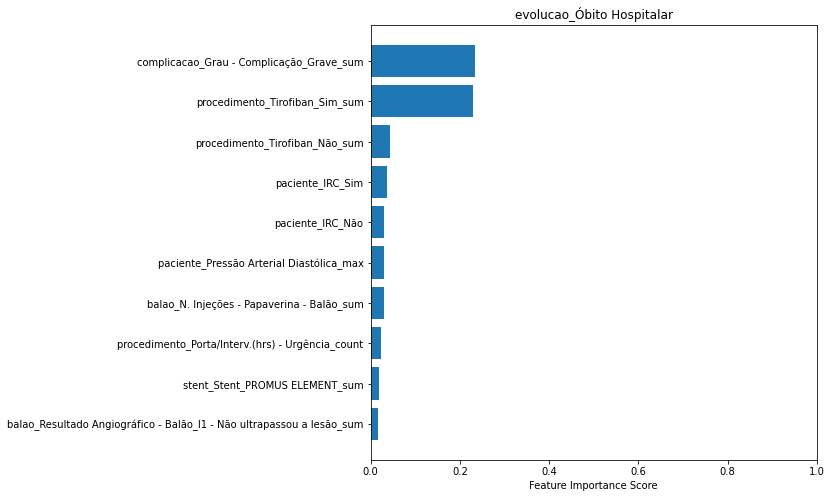


Predictions for  imputed_ADASYN_evolucao_Óbito Hospitalar_DecisionTree
Predicting on traning...imputed_ADASYN_evolucao_Óbito Hospitalar_DecisionTree
Value counts
0    6096
1    6074
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6074
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6074

    accuracy                           1.00     12170
   macro avg       1.00      1.00      1.00     12170
weighted avg       1.00      1.00      1.00     12170

True positive rate:  1.0
Predicting on validation...imputed_ADASYN_evolucao_Óbito Hospitalar_DecisionTree
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9831715210355987
tn: 1515 fp: 19 fn: 7 tp: 4
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1534
           1       0.17      0.36      0.24        11

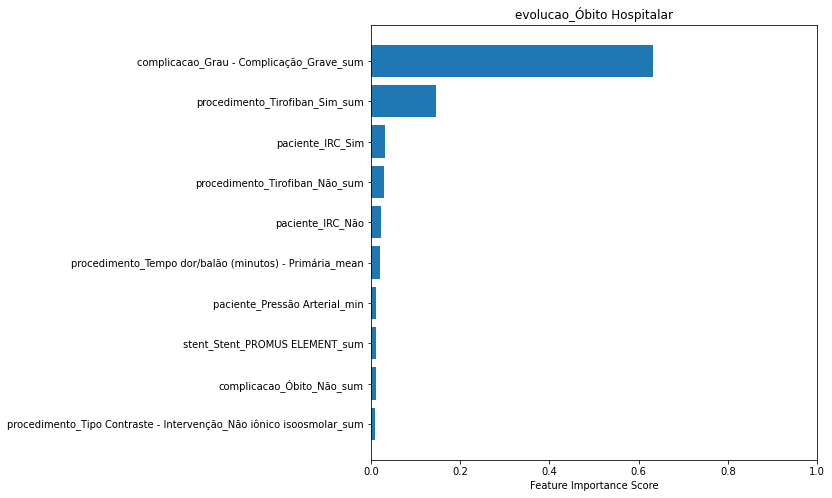


Predictions for  imputed_ADASYN_evolucao_Óbito Hospitalar_RandomForestClassifier
Predicting on traning...imputed_ADASYN_evolucao_Óbito Hospitalar_RandomForestClassifier
Value counts
0    6096
1    6074
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6074
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6074

    accuracy                           1.00     12170
   macro avg       1.00      1.00      1.00     12170
weighted avg       1.00      1.00      1.00     12170

True positive rate:  1.0
Predicting on validation...imputed_ADASYN_evolucao_Óbito Hospitalar_RandomForestClassifier
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9928802588996763
tn: 1534 fp: 0 fn: 11 tp: 0
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1534
           1       0.00

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


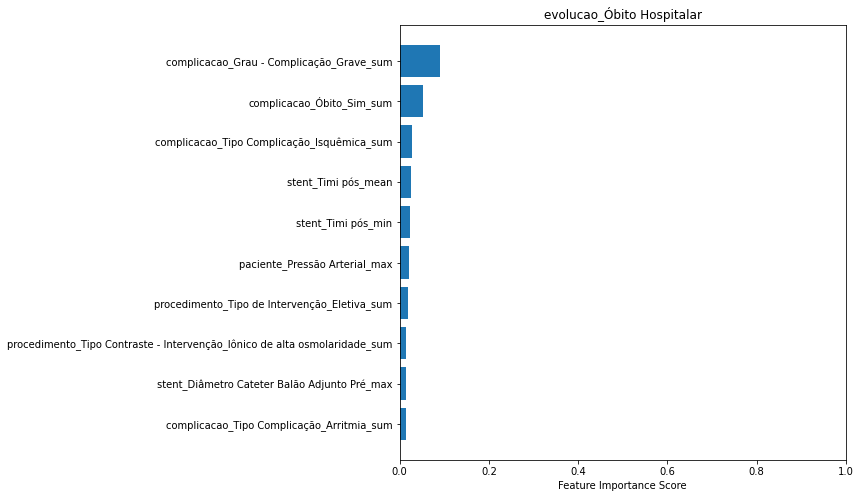


Predictions for  imputed_ADASYN_evolucao_Óbito Hospitalar_logistic
Predicting on traning...imputed_ADASYN_evolucao_Óbito Hospitalar_logistic
Value counts
0    6096
1    6074
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8348397699260477
tn: 5125 fp: 971 fn: 1039 tp: 5035
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      6096
           1       0.84      0.83      0.83      6074

    accuracy                           0.83     12170
   macro avg       0.83      0.83      0.83     12170
weighted avg       0.83      0.83      0.83     12170

True positive rate:  0.8289430358906816
Predicting on validation...imputed_ADASYN_evolucao_Óbito Hospitalar_logistic
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8381877022653722
tn: 1287 fp: 247 fn: 3 tp: 8
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1534
           1       0.03      

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_ADASYN_evolucao_Óbito Hospitalar_svm
Predicting on traning...imputed_ADASYN_evolucao_Óbito Hospitalar_svm
Value counts
0    6096
1    6074
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8622021364009861
tn: 5328 fp: 768 fn: 909 tp: 5165
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6096
           1       0.87      0.85      0.86      6074

    accuracy                           0.86     12170
   macro avg       0.86      0.86      0.86     12170
weighted avg       0.86      0.86      0.86     12170

True positive rate:  0.8503457359236088
Predicting on validation...imputed_ADASYN_evolucao_Óbito Hospitalar_svm
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8627831715210356
tn: 1327 fp: 207 fn: 5 tp: 6
              precision    recall  f1-score   support

           0       1.00      0.87  

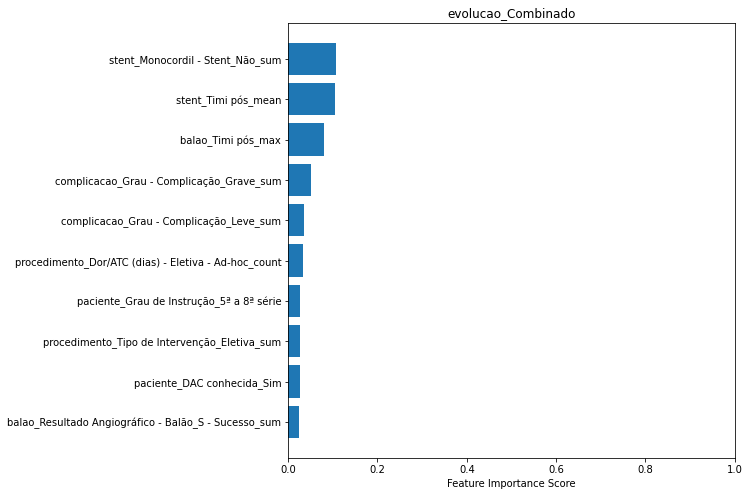


Predictions for  imputed_ADASYN_evolucao_Combinado_DecisionTree
Predicting on traning...imputed_ADASYN_evolucao_Combinado_DecisionTree
Value counts
1    5917
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 5910 fp: 0 fn: 0 tp: 5917
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5910
           1       1.00      1.00      1.00      5917

    accuracy                           1.00     11827
   macro avg       1.00      1.00      1.00     11827
weighted avg       1.00      1.00      1.00     11827

True positive rate:  1.0
Predicting on validation...imputed_ADASYN_evolucao_Combinado_DecisionTree
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.9333333333333333
tn: 1424 fp: 52 fn: 51 tp: 18
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1476
           1       0.26      0.26      0.26        69

    accuracy                   

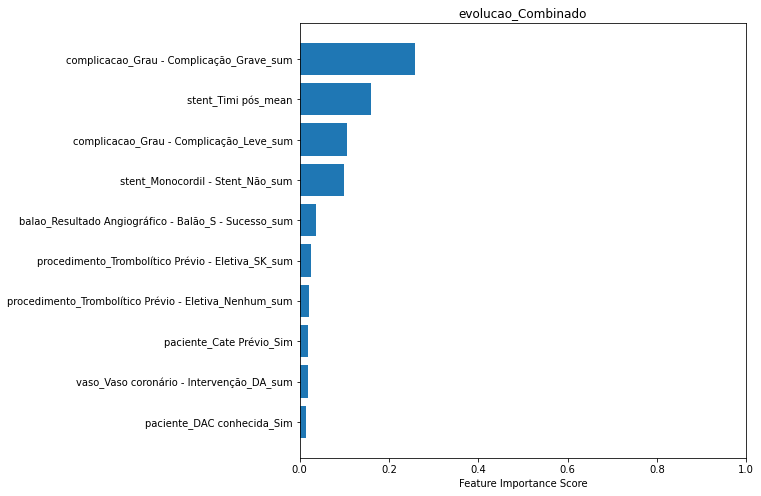


Predictions for  imputed_ADASYN_evolucao_Combinado_RandomForestClassifier
Predicting on traning...imputed_ADASYN_evolucao_Combinado_RandomForestClassifier
Value counts
1    5917
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 5910 fp: 0 fn: 0 tp: 5917
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5910
           1       1.00      1.00      1.00      5917

    accuracy                           1.00     11827
   macro avg       1.00      1.00      1.00     11827
weighted avg       1.00      1.00      1.00     11827

True positive rate:  1.0
Predicting on validation...imputed_ADASYN_evolucao_Combinado_RandomForestClassifier
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.9579288025889967
tn: 1471 fp: 5 fn: 60 tp: 9
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1476
           1       0.64      0.13      0.22        69

   

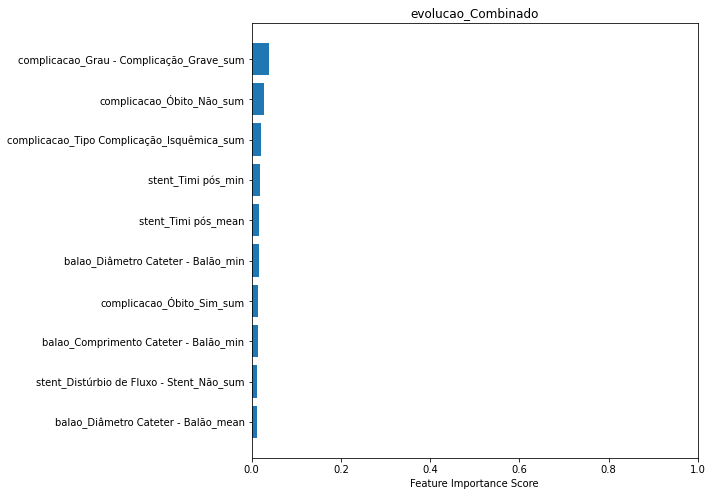


Predictions for  imputed_ADASYN_evolucao_Combinado_logistic
Predicting on traning...imputed_ADASYN_evolucao_Combinado_logistic
Value counts
1    5917
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  0.7156506299146022
tn: 4671 fp: 1239 fn: 2124 tp: 3793
              precision    recall  f1-score   support

           0       0.69      0.79      0.74      5910
           1       0.75      0.64      0.69      5917

    accuracy                           0.72     11827
   macro avg       0.72      0.72      0.71     11827
weighted avg       0.72      0.72      0.71     11827

True positive rate:  0.641034307926314
Predicting on validation...imputed_ADASYN_evolucao_Combinado_logistic
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.7786407766990291
tn: 1163 fp: 313 fn: 29 tp: 40
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      1476
           1       0.11      0.58      0.19        69

    acc

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_ADASYN_evolucao_Combinado_svm
Predicting on traning...imputed_ADASYN_evolucao_Combinado_svm
Value counts
1    5917
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  0.7203010061723176
tn: 4932 fp: 978 fn: 2330 tp: 3587
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      5910
           1       0.79      0.61      0.68      5917

    accuracy                           0.72     11827
   macro avg       0.73      0.72      0.72     11827
weighted avg       0.73      0.72      0.72     11827

True positive rate:  0.606219367922934
Predicting on validation...imputed_ADASYN_evolucao_Combinado_svm
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.8148867313915857
tn: 1224 fp: 252 fn: 34 tp: 35
              precision    recall  f1-score   support

           0       0.97      0.83      0.90      1476
           1  

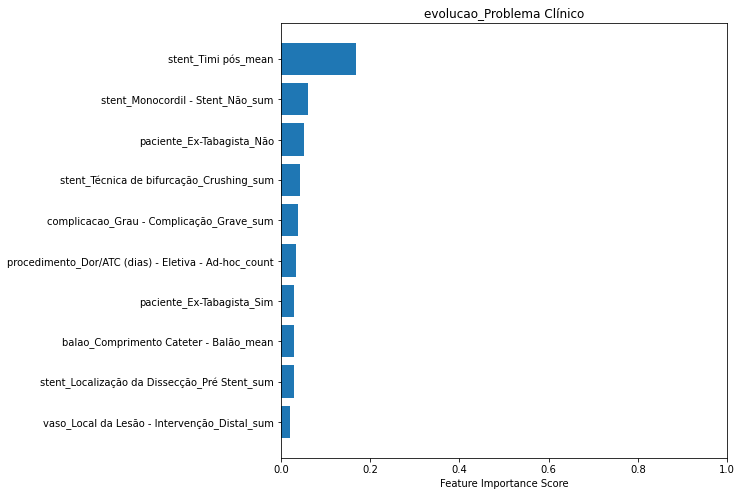


Predictions for  imputed_SMOTE_evolucao_Problema Clínico_DecisionTree
Predicting on traning...imputed_SMOTE_evolucao_Problema Clínico_DecisionTree
Value counts
1    5938
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 5938 fp: 0 fn: 0 tp: 5938
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5938
           1       1.00      1.00      1.00      5938

    accuracy                           1.00     11876
   macro avg       1.00      1.00      1.00     11876
weighted avg       1.00      1.00      1.00     11876

True positive rate:  1.0
Predicting on validation...imputed_SMOTE_evolucao_Problema Clínico_DecisionTree
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9398058252427185
tn: 1431 fp: 50 fn: 43 tp: 21
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1481
           1       0.30      0.33      0.31        64


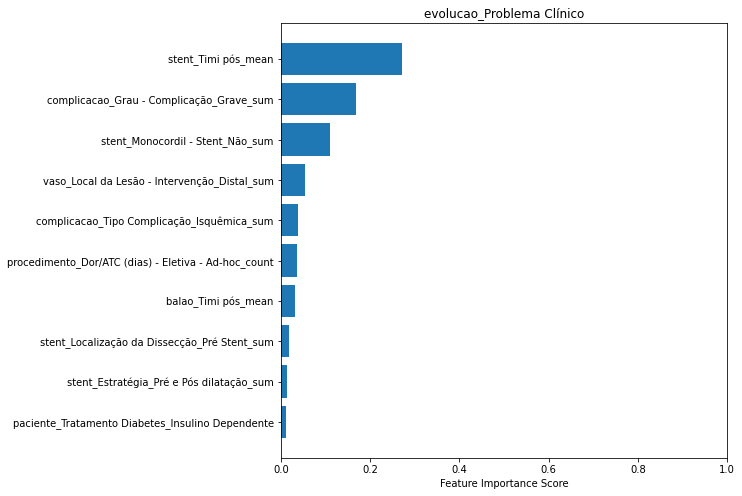


Predictions for  imputed_SMOTE_evolucao_Problema Clínico_RandomForestClassifier
Predicting on traning...imputed_SMOTE_evolucao_Problema Clínico_RandomForestClassifier
Value counts
1    5938
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 5938 fp: 0 fn: 0 tp: 5938
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5938
           1       1.00      1.00      1.00      5938

    accuracy                           1.00     11876
   macro avg       1.00      1.00      1.00     11876
weighted avg       1.00      1.00      1.00     11876

True positive rate:  1.0
Predicting on validation...imputed_SMOTE_evolucao_Problema Clínico_RandomForestClassifier
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9598705501618123
tn: 1476 fp: 5 fn: 57 tp: 7
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1481
           1       0.58   

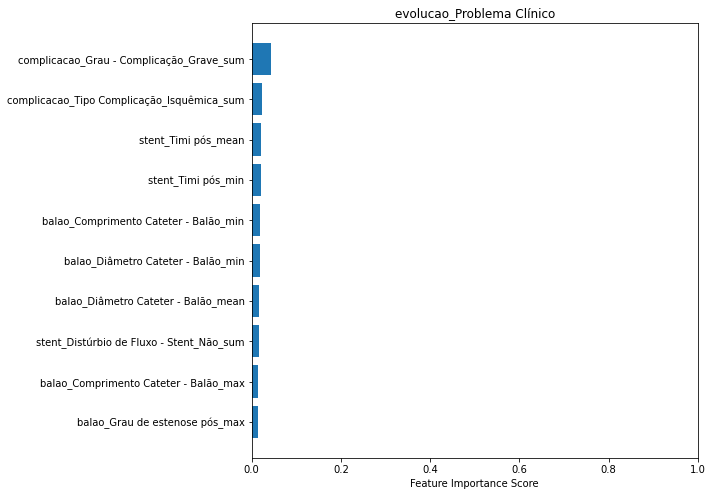


Predictions for  imputed_SMOTE_evolucao_Problema Clínico_logistic
Predicting on traning...imputed_SMOTE_evolucao_Problema Clínico_logistic
Value counts
1    5938
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.7558942404850117
tn: 4887 fp: 1051 fn: 1848 tp: 4090
              precision    recall  f1-score   support

           0       0.73      0.82      0.77      5938
           1       0.80      0.69      0.74      5938

    accuracy                           0.76     11876
   macro avg       0.76      0.76      0.75     11876
weighted avg       0.76      0.76      0.75     11876

True positive rate:  0.6887841023913776
Predicting on validation...imputed_SMOTE_evolucao_Problema Clínico_logistic
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.8058252427184466
tn: 1208 fp: 273 fn: 27 tp: 37
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1481
           1       0.12      

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_SMOTE_evolucao_Problema Clínico_svm
Predicting on traning...imputed_SMOTE_evolucao_Problema Clínico_svm
Value counts
1    5938
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.7501684068710003
tn: 5177 fp: 761 fn: 2206 tp: 3732
              precision    recall  f1-score   support

           0       0.70      0.87      0.78      5938
           1       0.83      0.63      0.72      5938

    accuracy                           0.75     11876
   macro avg       0.77      0.75      0.75     11876
weighted avg       0.77      0.75      0.75     11876

True positive rate:  0.628494442573257
Predicting on validation...imputed_SMOTE_evolucao_Problema Clínico_svm
Value counts
0    1481
1      64
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.8472491909385114
tn: 1276 fp: 205 fn: 31 tp: 33
              precision    recall  f1-score   support

           0       0.98      0.86   

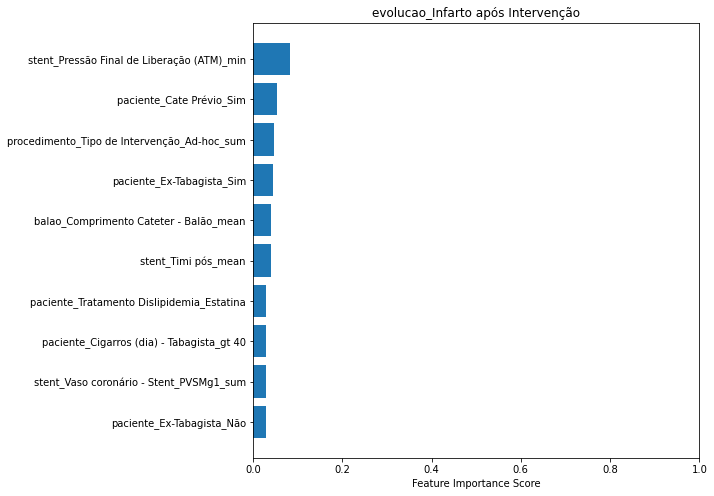


Predictions for  imputed_SMOTE_evolucao_Infarto após Intervenção_DecisionTree
Predicting on traning...imputed_SMOTE_evolucao_Infarto após Intervenção_DecisionTree
Value counts
1    6064
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 6064
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00      6064

    accuracy                           1.00     12128
   macro avg       1.00      1.00      1.00     12128
weighted avg       1.00      1.00      1.00     12128

True positive rate:  1.0
Predicting on validation...imputed_SMOTE_evolucao_Infarto após Intervenção_DecisionTree
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9566343042071197
tn: 1476 fp: 29 fn: 38 tp: 2
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1505
           1   

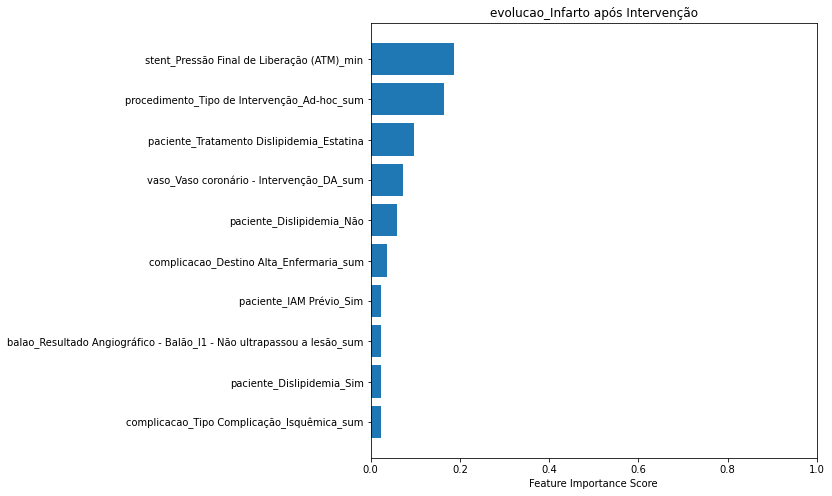


Predictions for  imputed_SMOTE_evolucao_Infarto após Intervenção_RandomForestClassifier
Predicting on traning...imputed_SMOTE_evolucao_Infarto após Intervenção_RandomForestClassifier
Value counts
1    6064
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 6064
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00      6064

    accuracy                           1.00     12128
   macro avg       1.00      1.00      1.00     12128
weighted avg       1.00      1.00      1.00     12128

True positive rate:  1.0
Predicting on validation...imputed_SMOTE_evolucao_Infarto após Intervenção_RandomForestClassifier
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.9741100323624595
tn: 1505 fp: 0 fn: 40 tp: 0
              precision    recall  f1-score   support

           0       0.97      1.00      0

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


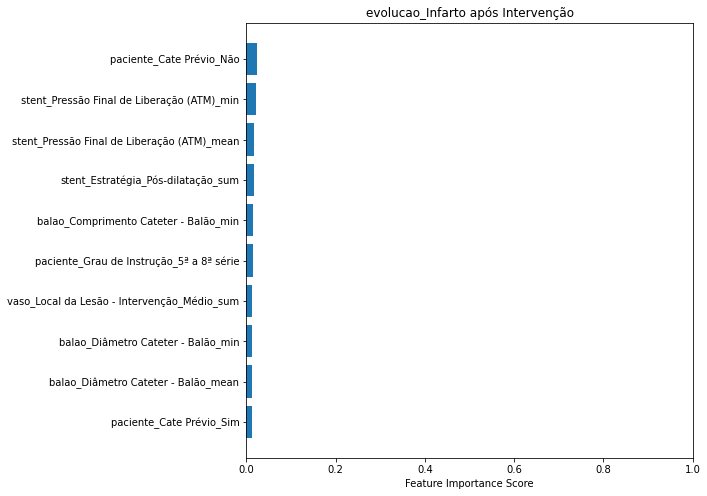


Predictions for  imputed_SMOTE_evolucao_Infarto após Intervenção_logistic
Predicting on traning...imputed_SMOTE_evolucao_Infarto após Intervenção_logistic
Value counts
1    6064
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7296339050131926
tn: 4600 fp: 1464 fn: 1815 tp: 4249
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      6064
           1       0.74      0.70      0.72      6064

    accuracy                           0.73     12128
   macro avg       0.73      0.73      0.73     12128
weighted avg       0.73      0.73      0.73     12128

True positive rate:  0.7006926121372031
Predicting on validation...imputed_SMOTE_evolucao_Infarto após Intervenção_logistic
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7611650485436893
tn: 1156 fp: 349 fn: 20 tp: 20
              precision    recall  f1-score   support

           0       0.98      0.77      0.86

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_SMOTE_evolucao_Infarto após Intervenção_svm
Predicting on traning...imputed_SMOTE_evolucao_Infarto após Intervenção_svm
Value counts
1    6064
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7542051451187335
tn: 4509 fp: 1555 fn: 1426 tp: 4638
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      6064
           1       0.75      0.76      0.76      6064

    accuracy                           0.75     12128
   macro avg       0.75      0.75      0.75     12128
weighted avg       0.75      0.75      0.75     12128

True positive rate:  0.7648416886543535
Predicting on validation...imputed_SMOTE_evolucao_Infarto após Intervenção_svm
Value counts
0    1505
1      40
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  0.7281553398058253
tn: 1105 fp: 400 fn: 20 tp: 20
              precision    recall  f1-score   sup

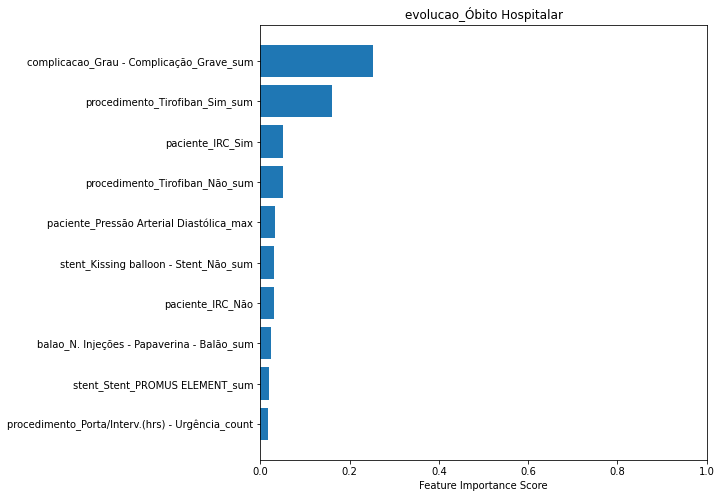


Predictions for  imputed_SMOTE_evolucao_Óbito Hospitalar_DecisionTree
Predicting on traning...imputed_SMOTE_evolucao_Óbito Hospitalar_DecisionTree
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6096

    accuracy                           1.00     12192
   macro avg       1.00      1.00      1.00     12192
weighted avg       1.00      1.00      1.00     12192

True positive rate:  1.0
Predicting on validation...imputed_SMOTE_evolucao_Óbito Hospitalar_DecisionTree
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9831715210355987
tn: 1515 fp: 19 fn: 7 tp: 4
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1534
           1       0.17      0.36      0.24        11

 

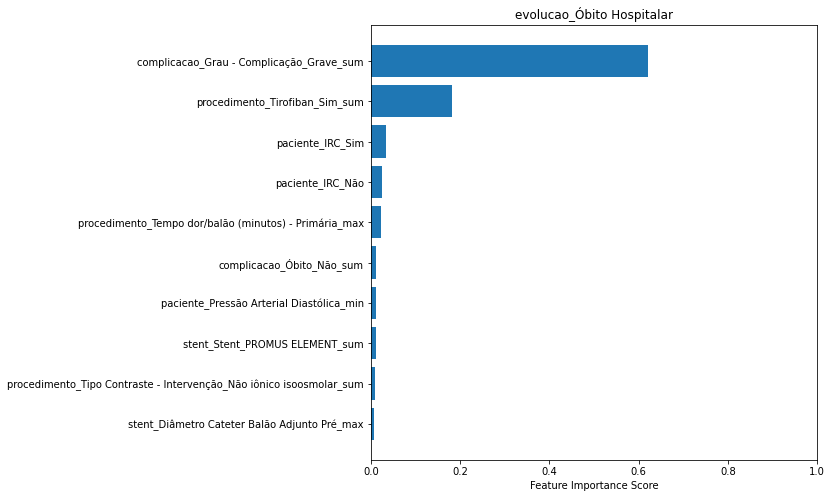


Predictions for  imputed_SMOTE_evolucao_Óbito Hospitalar_RandomForestClassifier
Predicting on traning...imputed_SMOTE_evolucao_Óbito Hospitalar_RandomForestClassifier
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6096

    accuracy                           1.00     12192
   macro avg       1.00      1.00      1.00     12192
weighted avg       1.00      1.00      1.00     12192

True positive rate:  1.0
Predicting on validation...imputed_SMOTE_evolucao_Óbito Hospitalar_RandomForestClassifier
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.9928802588996763
tn: 1534 fp: 0 fn: 11 tp: 0
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1534
           1       0.00   

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


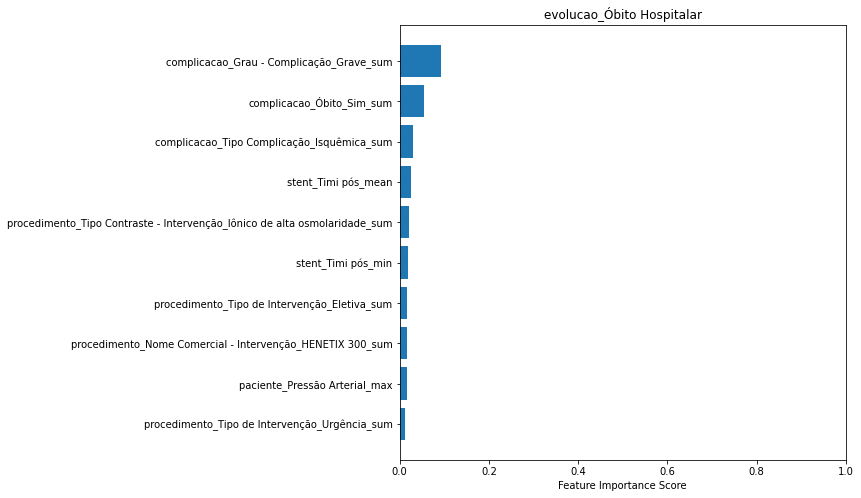


Predictions for  imputed_SMOTE_evolucao_Óbito Hospitalar_logistic
Predicting on traning...imputed_SMOTE_evolucao_Óbito Hospitalar_logistic
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.838008530183727
tn: 5154 fp: 942 fn: 1033 tp: 5063
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      6096
           1       0.84      0.83      0.84      6096

    accuracy                           0.84     12192
   macro avg       0.84      0.84      0.84     12192
weighted avg       0.84      0.84      0.84     12192

True positive rate:  0.8305446194225722
Predicting on validation...imputed_SMOTE_evolucao_Óbito Hospitalar_logistic
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8401294498381877
tn: 1290 fp: 244 fn: 3 tp: 8
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1534
           1       0.03      0.73

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_SMOTE_evolucao_Óbito Hospitalar_svm
Predicting on traning...imputed_SMOTE_evolucao_Óbito Hospitalar_svm
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8625328083989501
tn: 5352 fp: 744 fn: 932 tp: 5164
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      6096
           1       0.87      0.85      0.86      6096

    accuracy                           0.86     12192
   macro avg       0.86      0.86      0.86     12192
weighted avg       0.86      0.86      0.86     12192

True positive rate:  0.8471128608923885
Predicting on validation...imputed_SMOTE_evolucao_Óbito Hospitalar_svm
Value counts
0    1534
1      11
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  0.8627831715210356
tn: 1327 fp: 207 fn: 5 tp: 6
              precision    recall  f1-score   support

           0       1.00      0.87     

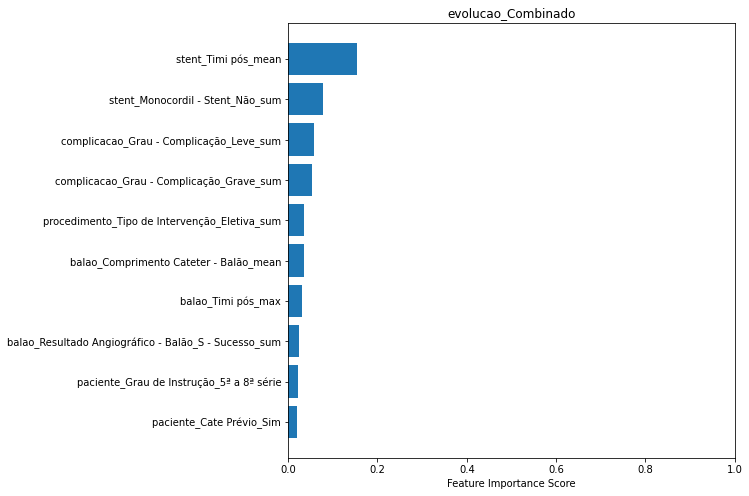


Predictions for  imputed_SMOTE_evolucao_Combinado_DecisionTree
Predicting on traning...imputed_SMOTE_evolucao_Combinado_DecisionTree
Value counts
1    5910
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 5910 fp: 0 fn: 0 tp: 5910
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5910
           1       1.00      1.00      1.00      5910

    accuracy                           1.00     11820
   macro avg       1.00      1.00      1.00     11820
weighted avg       1.00      1.00      1.00     11820

True positive rate:  1.0
Predicting on validation...imputed_SMOTE_evolucao_Combinado_DecisionTree
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.9326860841423948
tn: 1421 fp: 55 fn: 49 tp: 20
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1476
           1       0.27      0.29      0.28        69

    accuracy                      

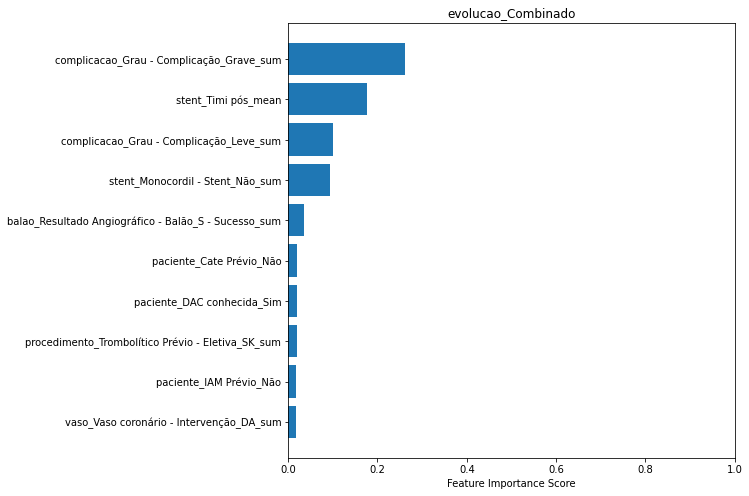


Predictions for  imputed_SMOTE_evolucao_Combinado_RandomForestClassifier
Predicting on traning...imputed_SMOTE_evolucao_Combinado_RandomForestClassifier
Value counts
1    5910
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 5910 fp: 0 fn: 0 tp: 5910
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5910
           1       1.00      1.00      1.00      5910

    accuracy                           1.00     11820
   macro avg       1.00      1.00      1.00     11820
weighted avg       1.00      1.00      1.00     11820

True positive rate:  1.0
Predicting on validation...imputed_SMOTE_evolucao_Combinado_RandomForestClassifier
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.9592233009708738
tn: 1472 fp: 4 fn: 59 tp: 10
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1476
           1       0.71      0.14      0.24        69

    a

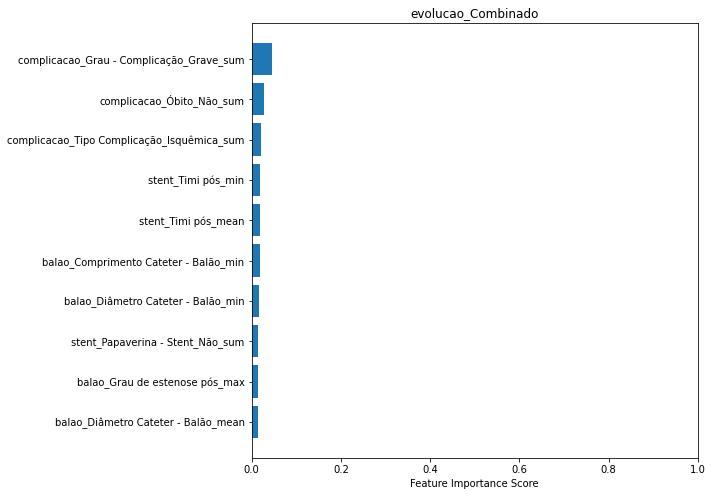


Predictions for  imputed_SMOTE_evolucao_Combinado_logistic
Predicting on traning...imputed_SMOTE_evolucao_Combinado_logistic
Value counts
1    5910
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  0.7328257191201354
tn: 4830 fp: 1080 fn: 2078 tp: 3832
              precision    recall  f1-score   support

           0       0.70      0.82      0.75      5910
           1       0.78      0.65      0.71      5910

    accuracy                           0.73     11820
   macro avg       0.74      0.73      0.73     11820
weighted avg       0.74      0.73      0.73     11820

True positive rate:  0.6483925549915398
Predicting on validation...imputed_SMOTE_evolucao_Combinado_logistic
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.7915857605177994
tn: 1188 fp: 288 fn: 34 tp: 35
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1476
           1       0.11      0.51      0.18        69

    accur

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression does not have feature_importances_ attribute

Predictions for  imputed_SMOTE_evolucao_Combinado_svm
Predicting on traning...imputed_SMOTE_evolucao_Combinado_svm
Value counts
1    5910
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  0.7379018612521151
tn: 5027 fp: 883 fn: 2215 tp: 3695
              precision    recall  f1-score   support

           0       0.69      0.85      0.76      5910
           1       0.81      0.63      0.70      5910

    accuracy                           0.74     11820
   macro avg       0.75      0.74      0.73     11820
weighted avg       0.75      0.74      0.73     11820

True positive rate:  0.6252115059221658
Predicting on validation...imputed_SMOTE_evolucao_Combinado_svm
Value counts
0    1476
1      69
Name: evolucao_Combinado, dtype: int64
Score:  0.8258899676375404
tn: 1242 fp: 234 fn: 35 tp: 34
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1476
           1    

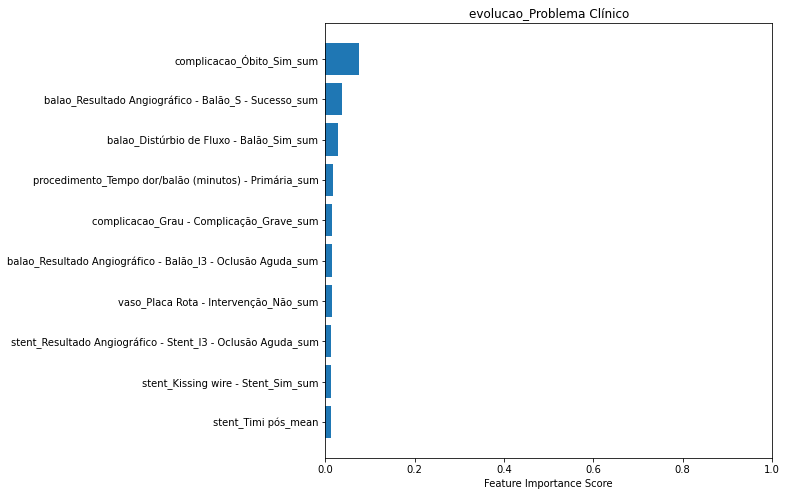


skipping not_imputed imbalanced evolucao_Problema Clínico DecisionTree
skipping not_imputed imbalanced evolucao_Problema Clínico RandomForestClassifier
skipping not_imputed imbalanced evolucao_Problema Clínico logistic
skipping not_imputed imbalanced evolucao_Problema Clínico svm
dataset label evolucao_Infarto após Intervenção
Predictions for  not_imputed_imbalanced_evolucao_Infarto após Intervenção_XGBoost
Predicting on traning...not_imputed_imbalanced_evolucao_Infarto após Intervenção_XGBoost
Value counts
0    6064
1     114
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 114
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00       114

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on valid

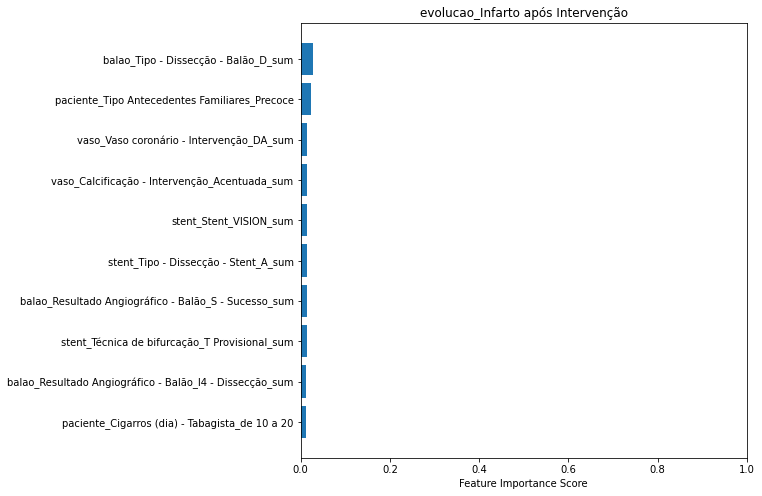


skipping not_imputed imbalanced evolucao_Infarto após Intervenção DecisionTree
skipping not_imputed imbalanced evolucao_Infarto após Intervenção RandomForestClassifier
skipping not_imputed imbalanced evolucao_Infarto após Intervenção logistic
skipping not_imputed imbalanced evolucao_Infarto após Intervenção svm
dataset label evolucao_Óbito Hospitalar
Predictions for  not_imputed_imbalanced_evolucao_Óbito Hospitalar_XGBoost
Predicting on traning...not_imputed_imbalanced_evolucao_Óbito Hospitalar_XGBoost
Value counts
0    6096
1      82
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 82
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00        82

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on valida

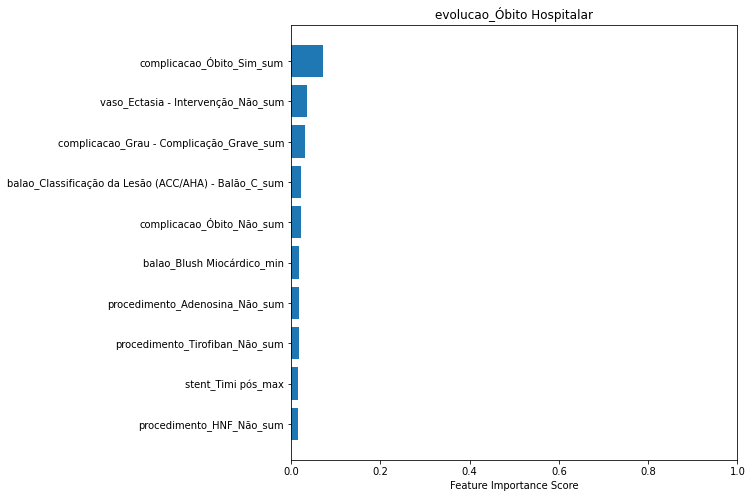


skipping not_imputed imbalanced evolucao_Óbito Hospitalar DecisionTree
skipping not_imputed imbalanced evolucao_Óbito Hospitalar RandomForestClassifier
skipping not_imputed imbalanced evolucao_Óbito Hospitalar logistic
skipping not_imputed imbalanced evolucao_Óbito Hospitalar svm
dataset label evolucao_Combinado
Predictions for  not_imputed_imbalanced_evolucao_Combinado_XGBoost
Predicting on traning...not_imputed_imbalanced_evolucao_Combinado_XGBoost
Value counts
0    5910
1     268
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 5910 fp: 0 fn: 0 tp: 268
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5910
           1       1.00      1.00      1.00       268

    accuracy                           1.00      6178
   macro avg       1.00      1.00      1.00      6178
weighted avg       1.00      1.00      1.00      6178

True positive rate:  1.0
Predicting on validation...not_imputed_imbalanced_evolucao_Combinado_XGBoost
Va

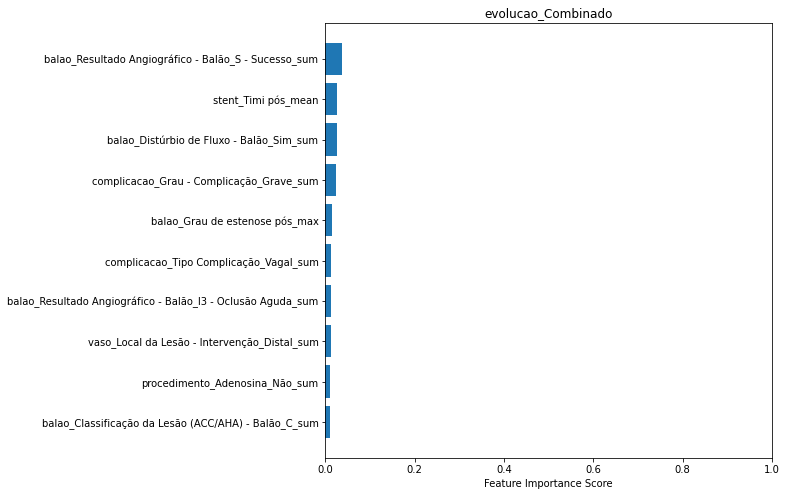


skipping not_imputed imbalanced evolucao_Combinado DecisionTree
skipping not_imputed imbalanced evolucao_Combinado RandomForestClassifier
skipping not_imputed imbalanced evolucao_Combinado logistic
skipping not_imputed imbalanced evolucao_Combinado svm
strategy RandomOverSampler
dataset label evolucao_Problema Clínico
Predictions for  not_imputed_RandomOverSampler_evolucao_Problema Clínico_XGBoost
Predicting on traning...not_imputed_RandomOverSampler_evolucao_Problema Clínico_XGBoost
Value counts
1    5938
0    5938
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 5938 fp: 0 fn: 0 tp: 5938
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5938
           1       1.00      1.00      1.00      5938

    accuracy                           1.00     11876
   macro avg       1.00      1.00      1.00     11876
weighted avg       1.00      1.00      1.00     11876

True positive rate:  1.0
Predicting on validation...not_impute

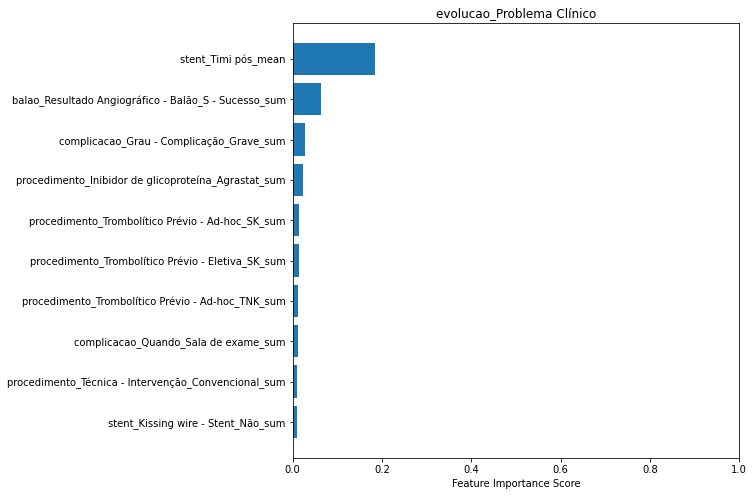


skipping not_imputed RandomOverSampler evolucao_Problema Clínico DecisionTree
skipping not_imputed RandomOverSampler evolucao_Problema Clínico RandomForestClassifier
skipping not_imputed RandomOverSampler evolucao_Problema Clínico logistic
skipping not_imputed RandomOverSampler evolucao_Problema Clínico svm
dataset label evolucao_Infarto após Intervenção
Predictions for  not_imputed_RandomOverSampler_evolucao_Infarto após Intervenção_XGBoost
Predicting on traning...not_imputed_RandomOverSampler_evolucao_Infarto após Intervenção_XGBoost
Value counts
1    6064
0    6064
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 6064 fp: 0 fn: 0 tp: 6064
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6064
           1       1.00      1.00      1.00      6064

    accuracy                           1.00     12128
   macro avg       1.00      1.00      1.00     12128
weighted avg       1.00      1.00      1.00     12128

T

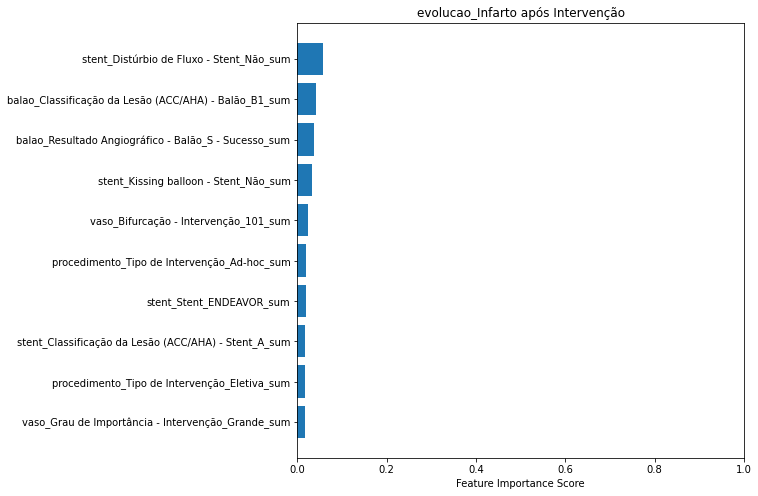


skipping not_imputed RandomOverSampler evolucao_Infarto após Intervenção DecisionTree
skipping not_imputed RandomOverSampler evolucao_Infarto após Intervenção RandomForestClassifier
skipping not_imputed RandomOverSampler evolucao_Infarto após Intervenção logistic
skipping not_imputed RandomOverSampler evolucao_Infarto após Intervenção svm
dataset label evolucao_Óbito Hospitalar
Predictions for  not_imputed_RandomOverSampler_evolucao_Óbito Hospitalar_XGBoost
Predicting on traning...not_imputed_RandomOverSampler_evolucao_Óbito Hospitalar_XGBoost
Value counts
1    6096
0    6096
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 6096 fp: 0 fn: 0 tp: 6096
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6096
           1       1.00      1.00      1.00      6096

    accuracy                           1.00     12192
   macro avg       1.00      1.00      1.00     12192
weighted avg       1.00      1.00      1.00     12192

T

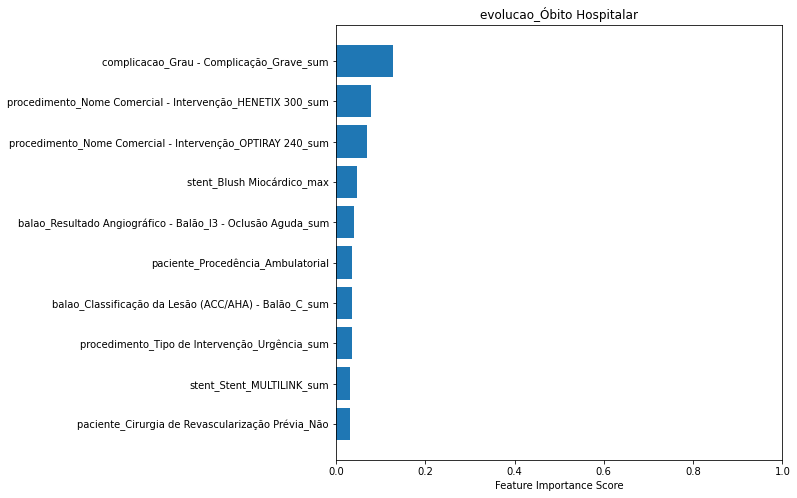


skipping not_imputed RandomOverSampler evolucao_Óbito Hospitalar DecisionTree
skipping not_imputed RandomOverSampler evolucao_Óbito Hospitalar RandomForestClassifier
skipping not_imputed RandomOverSampler evolucao_Óbito Hospitalar logistic
skipping not_imputed RandomOverSampler evolucao_Óbito Hospitalar svm
dataset label evolucao_Combinado
Predictions for  not_imputed_RandomOverSampler_evolucao_Combinado_XGBoost
Predicting on traning...not_imputed_RandomOverSampler_evolucao_Combinado_XGBoost
Value counts
1    5910
0    5910
Name: evolucao_Combinado, dtype: int64
Score:  0.9999153976311337
tn: 5909 fp: 1 fn: 0 tp: 5910
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5910
           1       1.00      1.00      1.00      5910

    accuracy                           1.00     11820
   macro avg       1.00      1.00      1.00     11820
weighted avg       1.00      1.00      1.00     11820

True positive rate:  1.0
Predicting on validat

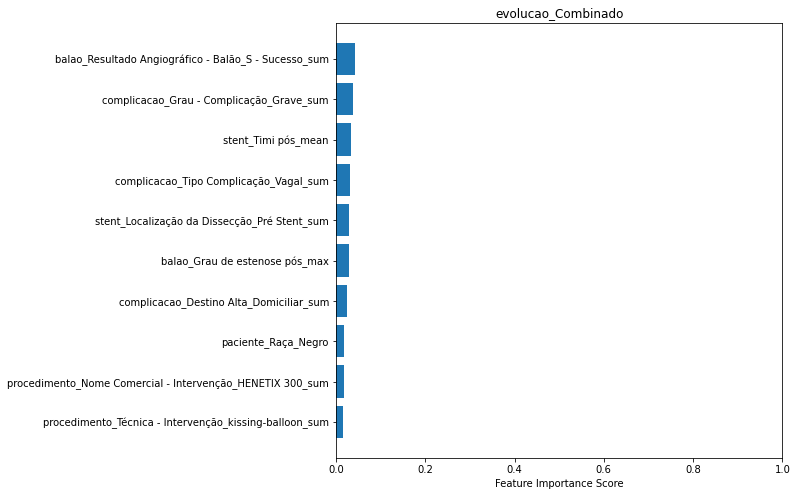


skipping not_imputed RandomOverSampler evolucao_Combinado DecisionTree
skipping not_imputed RandomOverSampler evolucao_Combinado RandomForestClassifier
skipping not_imputed RandomOverSampler evolucao_Combinado logistic
skipping not_imputed RandomOverSampler evolucao_Combinado svm
strategy RandomUnderSampler
dataset label evolucao_Problema Clínico
Predictions for  not_imputed_RandomUnderSampler_evolucao_Problema Clínico_XGBoost
Predicting on traning...not_imputed_RandomUnderSampler_evolucao_Problema Clínico_XGBoost
Value counts
1    240
0    240
Name: evolucao_Problema Clínico, dtype: int64
Score:  1.0
tn: 240 fp: 0 fn: 0 tp: 240
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       240

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

True positive rate:  1.0
Predicting

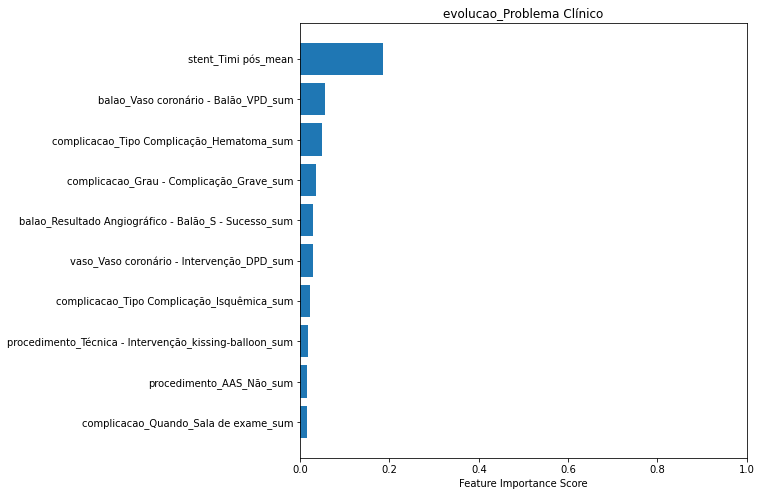


skipping not_imputed RandomUnderSampler evolucao_Problema Clínico DecisionTree
skipping not_imputed RandomUnderSampler evolucao_Problema Clínico RandomForestClassifier
skipping not_imputed RandomUnderSampler evolucao_Problema Clínico logistic
skipping not_imputed RandomUnderSampler evolucao_Problema Clínico svm
dataset label evolucao_Infarto após Intervenção
Predictions for  not_imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_XGBoost
Predicting on traning...not_imputed_RandomUnderSampler_evolucao_Infarto após Intervenção_XGBoost
Value counts
1    114
0    114
Name: evolucao_Infarto após Intervenção, dtype: int64
Score:  1.0
tn: 114 fp: 0 fn: 0 tp: 114
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00       114

    accuracy                           1.00       228
   macro avg       1.00      1.00      1.00       228
weighted avg       1.00      1.00      1.00       228


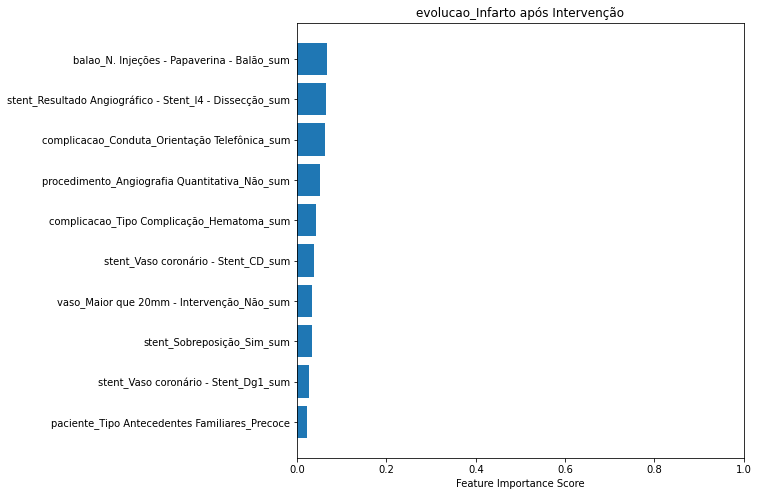


skipping not_imputed RandomUnderSampler evolucao_Infarto após Intervenção DecisionTree
skipping not_imputed RandomUnderSampler evolucao_Infarto após Intervenção RandomForestClassifier
skipping not_imputed RandomUnderSampler evolucao_Infarto após Intervenção logistic
skipping not_imputed RandomUnderSampler evolucao_Infarto após Intervenção svm
dataset label evolucao_Óbito Hospitalar
Predictions for  not_imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_XGBoost
Predicting on traning...not_imputed_RandomUnderSampler_evolucao_Óbito Hospitalar_XGBoost
Value counts
1    82
0    82
Name: evolucao_Óbito Hospitalar, dtype: int64
Score:  1.0
tn: 82 fp: 0 fn: 0 tp: 82
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        82

    accuracy                           1.00       164
   macro avg       1.00      1.00      1.00       164
weighted avg       1.00      1.00      1.00       164

Tru

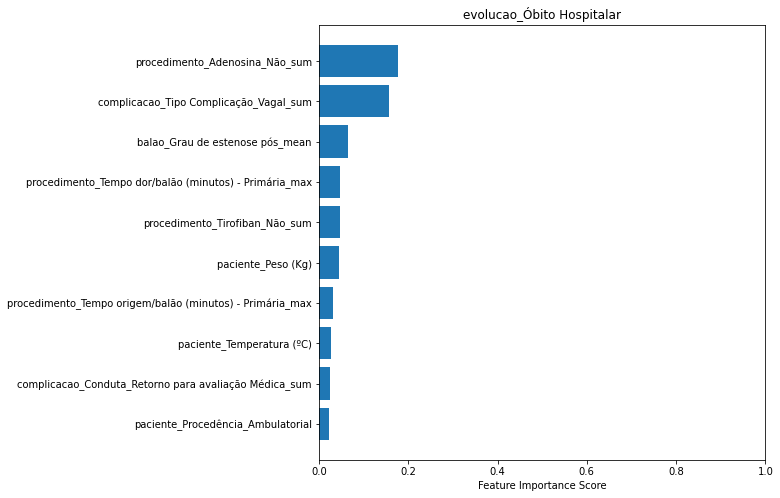


skipping not_imputed RandomUnderSampler evolucao_Óbito Hospitalar DecisionTree
skipping not_imputed RandomUnderSampler evolucao_Óbito Hospitalar RandomForestClassifier
skipping not_imputed RandomUnderSampler evolucao_Óbito Hospitalar logistic
skipping not_imputed RandomUnderSampler evolucao_Óbito Hospitalar svm
dataset label evolucao_Combinado
Predictions for  not_imputed_RandomUnderSampler_evolucao_Combinado_XGBoost
Predicting on traning...not_imputed_RandomUnderSampler_evolucao_Combinado_XGBoost
Value counts
1    268
0    268
Name: evolucao_Combinado, dtype: int64
Score:  1.0
tn: 268 fp: 0 fn: 0 tp: 268
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       268
           1       1.00      1.00      1.00       268

    accuracy                           1.00       536
   macro avg       1.00      1.00      1.00       536
weighted avg       1.00      1.00      1.00       536

True positive rate:  1.0
Predicting on validation...not_imp

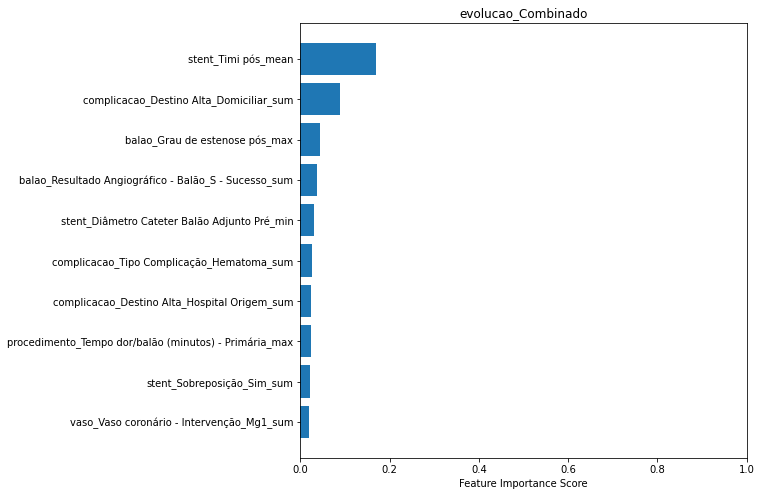


skipping not_imputed RandomUnderSampler evolucao_Combinado DecisionTree
skipping not_imputed RandomUnderSampler evolucao_Combinado RandomForestClassifier
skipping not_imputed RandomUnderSampler evolucao_Combinado logistic
skipping not_imputed RandomUnderSampler evolucao_Combinado svm
strategy ADASYN
strategy SMOTE


In [109]:
trained_models = train_models(dataset)

In [110]:
def compute_metrics(y, true_y, index_label):
    tp = np.sum((y==1) & (true_y==1), axis=0)
    p = np.sum(true_y==1, axis=0)
    tn = np.sum((y==0) & (true_y==0), axis=0)
    n = np.sum(true_y==0, axis=0)
    fp = np.sum((y==1) & (true_y==0), axis=0)
    fn = np.sum((y==0) & (true_y==1), axis=0)
    t = p + n
    tpr = tp/p
    tnr = tn/n
    fpr = fp/n
    fnr = fn/p
    acc = (tp + tn)/(p + n)
    ba  = (tpr + tnr)/2
    f1  = (2*tp) / (2*tp + fp + fn)
    ppv = tp / (tp + fp)
    
    mcc = ((tp*tn) - (fp*fn))/math.sqrt( (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn) )

    cm = pd.DataFrame(np.array([t, p, tp, fp, n, tn, fn, ba, f1, ppv, tpr, tnr, fpr, fnr, acc, mcc]).reshape(1,16), \
                      index=[index_label], columns=['total', 'positives', 'tp', 'fp', 'negatives', 'tn', 'fn', 'balanced acc', 'F1', 'precision', 'Sensitivity recall tpr', 'Specificity tnr', 'fpr', 'fnr', 'acc', 'mcc'])
    cm = cm.round(2)
    return cm

In [111]:
metrics_train = []
metrics_valid = []
for table in trained_models.keys():
    print(table)
    print(trained_models[table].keys())
    for strategy in trained_models[table].keys():
        print(strategy)
        print(trained_models[table][strategy].keys())
        for label in trained_models[table][strategy].keys():
            print(label)
            print(trained_models[table][strategy][label].keys())
            df = dataset[table][strategy][label]
            for classifier in trained_models[table][strategy][label].keys():
                print(classifier)
                modelname = trained_models[table][strategy][label][classifier]
                file = open(modelname+'.model', 'rb')
                model = pickle.load(file)

                x = df['X']
                y = model.predict(x)
                true_y = df['y']
                metrics_train.append(compute_metrics(y,true_y.to_numpy().flatten(), f"{table} {strategy} {label} {classifier}"))

                x = df['X_valid']
                y = model.predict(x)
                true_y = df['y_valid']
                metrics_valid.append(compute_metrics(y,true_y.to_numpy().flatten(), f"{table} {strategy} {label} {classifier}"))

imputed
dict_keys(['imbalanced', 'RandomOverSampler', 'RandomUnderSampler', 'ADASYN', 'SMOTE'])
imbalanced
dict_keys(['evolucao_Problema Clínico', 'evolucao_Infarto após Intervenção', 'evolucao_Óbito Hospitalar', 'evolucao_Combinado'])
evolucao_Problema Clínico
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic
svm


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


evolucao_Infarto após Intervenção
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


logistic
svm


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


evolucao_Óbito Hospitalar
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


logistic
svm


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


evolucao_Combinado
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic
svm


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


RandomOverSampler
dict_keys(['evolucao_Problema Clínico', 'evolucao_Infarto após Intervenção', 'evolucao_Óbito Hospitalar', 'evolucao_Combinado'])
evolucao_Problema Clínico
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic
svm
evolucao_Infarto após Intervenção
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


logistic
svm
evolucao_Óbito Hospitalar
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


logistic
svm
evolucao_Combinado
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic
svm
RandomUnderSampler
dict_keys(['evolucao_Problema Clínico', 'evolucao_Infarto após Intervenção', 'evolucao_Óbito Hospitalar', 'evolucao_Combinado'])
evolucao_Problema Clínico
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic
svm
evolucao_Infarto após Intervenção
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic
svm
evolucao_Óbito Hospitalar
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic
svm
evolucao_Combinado
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic
svm
ADASYN
dic

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


DecisionTree
RandomForestClassifier


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


logistic
svm
evolucao_Óbito Hospitalar
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


svm
evolucao_Combinado
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic
svm
SMOTE
dict_keys(['evolucao_Problema Clínico', 'evolucao_Infarto após Intervenção', 'evolucao_Óbito Hospitalar', 'evolucao_Combinado'])
evolucao_Problema Clínico
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic
svm
evolucao_Infarto após Intervenção
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


logistic
svm
evolucao_Óbito Hospitalar
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic


/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


svm
evolucao_Combinado
dict_keys(['XGBoost', 'DecisionTree', 'RandomForestClassifier', 'logistic', 'svm'])
XGBoost
DecisionTree
RandomForestClassifier
logistic
svm
not_imputed
dict_keys(['imbalanced', 'RandomOverSampler', 'RandomUnderSampler', 'ADASYN', 'SMOTE'])
imbalanced
dict_keys(['evolucao_Problema Clínico', 'evolucao_Infarto após Intervenção', 'evolucao_Óbito Hospitalar', 'evolucao_Combinado'])
evolucao_Problema Clínico
dict_keys(['XGBoost'])
XGBoost
evolucao_Infarto após Intervenção
dict_keys(['XGBoost'])
XGBoost
evolucao_Óbito Hospitalar
dict_keys(['XGBoost'])
XGBoost
evolucao_Combinado
dict_keys(['XGBoost'])
XGBoost
RandomOverSampler
dict_keys(['evolucao_Problema Clínico', 'evolucao_Infarto após Intervenção', 'evolucao_Óbito Hospitalar', 'evolucao_Combinado'])
evolucao_Problema Clínico
dict_keys(['XGBoost'])
XGBoost
evolucao_Infarto após Intervenção
dict_keys(['XGBoost'])
XGBoost
evolucao_Óbito Hospitalar
dict_keys(['XGBoost'])
XGBoost
evolucao_Combinado
dict_keys(['XGBoost'])

In [112]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/home/titobr/mestrado/mestrado-venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [113]:
df_metrics_train = pd.concat(metrics_train)
df_metrics_train.to_csv("metrics_train.csv")
df_metrics_train

,total,positives,tp,fp,negatives,tn,fn,balanced acc,F1,precision,Sensitivity recall tpr,Specificity tnr,fpr,fnr,acc,mcc
imputed imbalanced evolucao_Problema Clínico XGBoost,6178.0,240.0,240.0,0.0,5938.0,5938.0,0.0,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00
imputed imbalanced evolucao_Problema Clínico DecisionTree,6178.0,240.0,240.0,0.0,5938.0,5938.0,0.0,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00
imputed imbalanced evolucao_Problema Clínico RandomForestClassifier,6178.0,240.0,240.0,0.0,5938.0,5938.0,0.0,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00
imputed imbalanced evolucao_Problema Clínico logistic,6178.0,240.0,32.0,25.0,5938.0,5913.0,208.0,0.56,0.22,0.56,0.13,1.00,0.00,0.87,0.96,0.26
imputed imbalanced evolucao_Problema Clínico svm,6178.0,240.0,2.0,0.0,5938.0,5938.0,238.0,0.50,0.02,1.00,0.01,1.00,0.00,0.99,0.96,0.09
imputed imbalanced evolucao_Infarto após Intervenção XGBoost,6178.0,114.0,114.0,0.0,6064.0,6064.0,0.0,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00
imputed imbalanced evolucao_Infarto após Intervenção DecisionTree,6178.0,114.0,114.0,0.0,6064.0,6064.0,0.0,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00
imputed imbalanced evolucao_Infarto após Intervenção RandomForestClassifier,6178.0,114.0,114.0,0.0,6064.0,6064.0,0.0,1.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00
imputed imbalanced evolucao_Infarto após Intervenção logistic,6178.0,114.0,2.0,3.0,6064.0,6061.0,112.0,0.51,0.03,0.40,0.02,1.00,0.00,0.98,0.98,0.08
imputed imbalanced evolucao_Infarto após Intervenção svm,6178.0,114.0,1.0,0.0,6064.0,6064.0,113.0,0.50,0.02,1.00,0.01,1.00,0.00,0.99,0.98,0.09


In [114]:
df_metrics_valid = pd.concat(metrics_valid)
df_metrics_valid.to_csv("metrics_valid.csv")
df_metrics_valid

,total,positives,tp,fp,negatives,tn,fn,balanced acc,F1,precision,Sensitivity recall tpr,Specificity tnr,fpr,fnr,acc,mcc
imputed imbalanced evolucao_Problema Clínico XGBoost,1545.0,64.0,10.0,6.0,1481.0,1475.0,54.0,0.58,0.25,0.62,0.16,1.00,0.00,0.84,0.96,0.30
imputed imbalanced evolucao_Problema Clínico DecisionTree,1545.0,64.0,18.0,53.0,1481.0,1428.0,46.0,0.62,0.27,0.25,0.28,0.96,0.04,0.72,0.94,0.23
imputed imbalanced evolucao_Problema Clínico RandomForestClassifier,1545.0,64.0,7.0,2.0,1481.0,1479.0,57.0,0.55,0.19,0.78,0.11,1.00,0.00,0.89,0.96,0.28
imputed imbalanced evolucao_Problema Clínico logistic,1545.0,64.0,11.0,9.0,1481.0,1472.0,53.0,0.58,0.26,0.55,0.17,0.99,0.01,0.83,0.96,0.29
imputed imbalanced evolucao_Problema Clínico svm,1545.0,64.0,0.0,0.0,1481.0,1481.0,64.0,0.50,0.00,NaN,0.00,1.00,0.00,1.00,0.96,NaN
imputed imbalanced evolucao_Infarto após Intervenção XGBoost,1545.0,40.0,0.0,1.0,1505.0,1504.0,40.0,0.50,0.00,0.00,0.00,1.00,0.00,1.00,0.97,-0.00
imputed imbalanced evolucao_Infarto após Intervenção DecisionTree,1545.0,40.0,2.0,24.0,1505.0,1481.0,38.0,0.52,0.06,0.08,0.05,0.98,0.02,0.95,0.96,0.04
imputed imbalanced evolucao_Infarto após Intervenção RandomForestClassifier,1545.0,40.0,0.0,0.0,1505.0,1505.0,40.0,0.50,0.00,NaN,0.00,1.00,0.00,1.00,0.97,NaN
imputed imbalanced evolucao_Infarto após Intervenção logistic,1545.0,40.0,0.0,0.0,1505.0,1505.0,40.0,0.50,0.00,NaN,0.00,1.00,0.00,1.00,0.97,NaN
imputed imbalanced evolucao_Infarto após Intervenção svm,1545.0,40.0,0.0,0.0,1505.0,1505.0,40.0,0.50,0.00,NaN,0.00,1.00,0.00,1.00,0.97,NaN


#### Apesar do dataset conter várias variáveis resposta (labels) focaremos os resultados apenas na "evolucao_Problema Clínico"

In [115]:
df_metrics_valid[["evolucao_Problema Clínico" in label for label in df_metrics_valid.index.values.tolist()]]

,total,positives,tp,fp,negatives,tn,fn,balanced acc,F1,precision,Sensitivity recall tpr,Specificity tnr,fpr,fnr,acc,mcc
imputed imbalanced evolucao_Problema Clínico XGBoost,1545.0,64.0,10.0,6.0,1481.0,1475.0,54.0,0.58,0.25,0.62,0.16,1.00,0.00,0.84,0.96,0.30
imputed imbalanced evolucao_Problema Clínico DecisionTree,1545.0,64.0,18.0,53.0,1481.0,1428.0,46.0,0.62,0.27,0.25,0.28,0.96,0.04,0.72,0.94,0.23
imputed imbalanced evolucao_Problema Clínico RandomForestClassifier,1545.0,64.0,7.0,2.0,1481.0,1479.0,57.0,0.55,0.19,0.78,0.11,1.00,0.00,0.89,0.96,0.28
imputed imbalanced evolucao_Problema Clínico logistic,1545.0,64.0,11.0,9.0,1481.0,1472.0,53.0,0.58,0.26,0.55,0.17,0.99,0.01,0.83,0.96,0.29
imputed imbalanced evolucao_Problema Clínico svm,1545.0,64.0,0.0,0.0,1481.0,1481.0,64.0,0.50,0.00,NaN,0.00,1.00,0.00,1.00,0.96,NaN
imputed RandomOverSampler evolucao_Problema Clínico XGBoost,1545.0,64.0,17.0,21.0,1481.0,1460.0,47.0,0.63,0.33,0.45,0.27,0.99,0.01,0.73,0.96,0.32
imputed RandomOverSampler evolucao_Problema Clínico DecisionTree,1545.0,64.0,14.0,54.0,1481.0,1427.0,50.0,0.59,0.21,0.21,0.22,0.96,0.04,0.78,0.93,0.18
imputed RandomOverSampler evolucao_Problema Clínico RandomForestClassifier,1545.0,64.0,10.0,3.0,1481.0,1478.0,54.0,0.58,0.26,0.77,0.16,1.00,0.00,0.84,0.96,0.34
imputed RandomOverSampler evolucao_Problema Clínico logistic,1545.0,64.0,37.0,267.0,1481.0,1214.0,27.0,0.70,0.20,0.12,0.58,0.82,0.18,0.42,0.81,0.20
imputed RandomOverSampler evolucao_Problema Clínico svm,1545.0,64.0,31.0,183.0,1481.0,1298.0,33.0,0.68,0.22,0.14,0.48,0.88,0.12,0.52,0.86,0.21


# Avaliação no conjunto de Teste

In [ ]:
test_df.drop(columns =[ \
    "evolucao_Infarto após Intervenção", \
    "evolucao_Óbito Hospitalar", \
    "evolucao_Complicação Vascular", \
    "evolucao_I.R.A", \
    "evolucao_I.R.A Dialítica", \
    "evolucao_A.V.C Hemorrágico", \
    "evolucao_A.V.C Isquêmico", \
    "evolucao_Combinado" \
], inplace=True)

In [117]:
x_df = test_df.filter(items=[col for col in test_df.columns if ('evolucao_' not in col)], axis=1)
y_df = test_df.filter(items=['evolucao_Problema Clínico'], axis=1)

Value counts
0    1838
1    75  
Name: evolucao_Problema Clínico, dtype: int64
Score:  0.9613173026659697
tn: 1813 fp: 25 fn: 49 tp: 26
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1838
           1       0.51      0.35      0.41        75

    accuracy                           0.96      1913
   macro avg       0.74      0.67      0.70      1913
weighted avg       0.96      0.96      0.96      1913

True positive rate:  0.3466666666666667


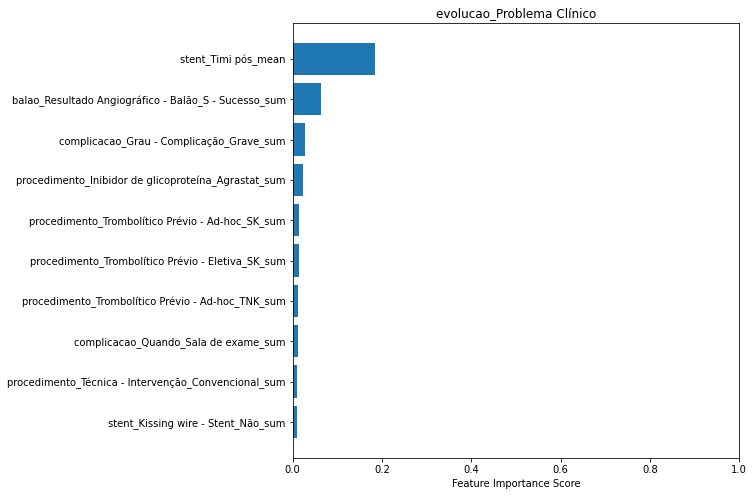

In [118]:
file = open('merged_RandomOverSampler_evolucao_Problema Clínico_XGBoost_none.model', 'rb')
model = pickle.load(file)
predict(model, x_df, y_df.iloc[:,0], True)

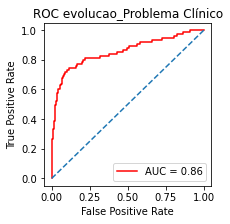

In [38]:
y_prob = model.predict_proba(x_df)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_df, y_prob[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(3,3))
plt.title('ROC {}'.format('evolucao_Problema Clínico'))
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Modelagem com redes neurais

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [41]:
print(tf.__version__)

2.2.0


In [92]:
# define a function to build the keras model
def create_model():
    initializer = tf.keras.initializers.GlorotUniform(seed=42)
    # create model
    model = Sequential()
    model.add(Dense(644, input_dim=644, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    adam = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC', 'Precision', 'Recall'])
    return model

model = create_model()

print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 644)               415380    
_________________________________________________________________
dropout_56 (Dropout)         (None, 644)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 512)               330240    
_________________________________________________________________
dropout_57 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_58 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 128)             

In [203]:
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
X = dataset['imputed']['RandomOverSampler']['evolucao_Problema Clínico']['X']
X_valid = dataset['imputed']['RandomOverSampler']['evolucao_Problema Clínico']['X_valid']
y = dataset['imputed']['RandomOverSampler']['evolucao_Problema Clínico']['y']
y_valid = dataset['imputed']['RandomOverSampler']['evolucao_Problema Clínico']['y_valid']

In [94]:
#history = model.fit(X, y, epochs=10)
es = EarlyStopping(monitor='val_auc', mode='max', min_delta=0.001, patience=5)
history = model.fit(X, y, batch_size=128, epochs=50, validation_data=(X_valid, y_valid), verbose=1)#callbacks=[es], verbose=1)

Epoch 1/50
93/93 [==============================] - 1s 14ms/step - loss: 0.8014 - auc: 0.8417 - precision: 0.8427 - recall: 0.6588 - val_loss: 0.7105 - val_auc: 0.7269 - val_precision: 0.1797 - val_recall: 0.3594
Epoch 2/50
93/93 [==============================] - 1s 15ms/step - loss: 0.7956 - auc: 0.8400 - precision: 0.8365 - recall: 0.6533 - val_loss: 0.6837 - val_auc: 0.7392 - val_precision: 0.1812 - val_recall: 0.3906
Epoch 3/50
93/93 [==============================] - 1s 14ms/step - loss: 0.7775 - auc: 0.8447 - precision: 0.8396 - recall: 0.6682 - val_loss: 0.6805 - val_auc: 0.6810 - val_precision: 0.1778 - val_recall: 0.3750
Epoch 4/50
93/93 [==============================] - 1s 15ms/step - loss: 0.7641 - auc: 0.8412 - precision: 0.8313 - recall: 0.6728 - val_loss: 0.6619 - val_auc: 0.6798 - val_precision: 0.1667 - val_recall: 0.2969
Epoch 5/50
93/93 [==============================] - 1s 15ms/step - loss: 0.7547 - auc: 0.8481 - precision: 0.8329 - recall: 0.6748 - val_loss: 0.644

93/93 [==============================] - 1s 15ms/step - loss: 0.5432 - auc: 0.8672 - precision: 0.8223 - recall: 0.7565 - val_loss: 0.4940 - val_auc: 0.6826 - val_precision: 0.1211 - val_recall: 0.4219
Epoch 40/50
93/93 [==============================] - 1s 16ms/step - loss: 0.5553 - auc: 0.8595 - precision: 0.8176 - recall: 0.7482 - val_loss: 0.5213 - val_auc: 0.6837 - val_precision: 0.0981 - val_recall: 0.4062
Epoch 41/50
93/93 [==============================] - 1s 15ms/step - loss: 0.5366 - auc: 0.8715 - precision: 0.8212 - recall: 0.7740 - val_loss: 0.4380 - val_auc: 0.6706 - val_precision: 0.1304 - val_recall: 0.3750
Epoch 42/50
93/93 [==============================] - 1s 15ms/step - loss: 0.5337 - auc: 0.8715 - precision: 0.8238 - recall: 0.7721 - val_loss: 0.4759 - val_auc: 0.6627 - val_precision: 0.0972 - val_recall: 0.3750
Epoch 43/50
93/93 [==============================] - 1s 16ms/step - loss: 0.5357 - auc: 0.8661 - precision: 0.8261 - recall: 0.7715 - val_loss: 0.5183 - val

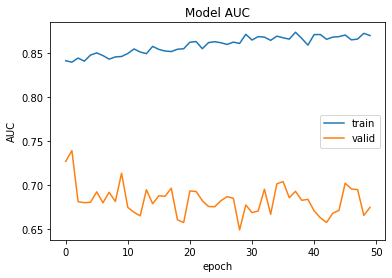

In [95]:
# Model accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

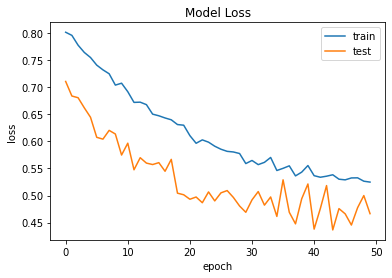

In [97]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [98]:
# generate classification report using predictions for binary model
from sklearn.metrics import classification_report, accuracy_score
# generate classification report using predictions for binary model 
binary_pred = np.round(model.predict(X_valid)).astype(int)
cm = metrics.confusion_matrix(y_valid.values, binary_pred)
if (cm.shape == (2,2)):
    tn, fp, fn, tp = cm.ravel()
    print('tn:', tn,'fp:', fp,'fn:', fn,'tp:', tp)
print('Results for Binary Model')
print(accuracy_score(y_valid, binary_pred))
print(classification_report(y_valid, binary_pred))

tn: 1274 fp: 207 fn: 40 tp: 24
Results for Binary Model
0.8401294498381877
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1481
           1       0.10      0.38      0.16        64

    accuracy                           0.84      1545
   macro avg       0.54      0.62      0.54      1545
weighted avg       0.93      0.84      0.88      1545

